In [1]:
# Standard library imports
import os
import random
import warnings

# Third-party library imports for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
import umap

# Machine Learning and statistical testing libraries
from scipy.stats import mannwhitneyu, f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import FitFailedWarning
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Survival analysis libraries
import sksurv
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

# Feature selection libraries
from boruta import BorutaPy

# Lifelines for additional survival analysis
from lifelines.statistics import logrank_test, multivariate_logrank_test


In [2]:
split_percentage = 0.5
scaler_type = "minmax" # "robust"
feature_Sel_type = "ElasticNet"
cohort = "RTOG_0521_OS_349feats"
l1_ratio = 0.7
max_days = 365*10
risk_treshold_method = "median"
num_features = 16

In [3]:
rtog_features_df = pd.read_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/RTOG_0521_features_immune_cells_349feats_all_events_time.csv', index_col=0)
#rename biochemical_failure to event
#rename biochemical_failure_years to time
rtog_features_df = rtog_features_df.rename(columns={"survival": "event", "survival_years": "time", "cn_deidentified": "patient_id"})
rtog_features_df = rtog_features_df.drop(columns=["disease_free_survival", "disease_free_survival_years", "biochemical_failure", "biochemical_failure_years", "any_distant_mets", "any_distant_mets_years", "local_failure", "local_failure_years"])

In [4]:
rtog_features_df

,patient_id,0,1,2,3,4,5,6,7,8,...,342,343,344,345,346,347,348,event,time,RX
0,0521-237186,2.313596,616639.821685,519807.230097,253030.706008,508293.281534,600273.001790,455779.993811,1.403957,0.340978,...,0.000190,0.000197,0.000116,0.000437,0.000014,1.427801,0.304765,0,12.569863,2
1,0521-972417,0.589928,505414.643734,422261.633692,166007.268837,408408.112421,488887.852076,373262.884875,1.587910,0.446749,...,0.000047,0.000055,0.000039,0.000115,0.000000,1.595238,0.445435,0,12.673973,2
2,0521-641497,2.381323,627747.801782,435220.419635,295462.699914,400895.284547,593381.427233,328999.414518,1.729252,0.552592,...,0.000088,0.000112,0.000050,0.000244,0.000000,1.800000,0.622561,0,12.783562,1
3,0521-650593,0.906250,387458.529518,216584.568696,178138.411204,180984.795893,357444.984298,122205.766406,1.595888,0.463885,...,0.000091,0.000091,0.000091,0.000181,0.000000,1.000000,0.000000,1,5.682192,1
4,0521-931689,3.090164,761431.020537,691778.504944,325600.109790,682585.737148,751566.377699,643983.422402,1.229924,0.244753,...,0.000359,0.000312,0.000355,0.000723,0.000044,1.543574,0.122749,0,12.468493,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0521-785941,3.281046,828746.757206,784322.551674,309274.865436,778774.983969,821132.968570,755178.209756,1.624910,0.489901,...,0.000147,0.000154,0.000092,0.000329,0.000000,1.511842,0.236840,0,9.619178,1
346,0521-227777,3.107306,742567.916680,653911.581944,299697.746032,644335.005238,727159.392769,596918.918362,1.564805,0.406043,...,0.000215,0.000212,0.000144,0.000476,0.000027,1.490400,0.354955,0,9.731507,2
347,0521-225186,3.624242,694474.155107,567604.665576,271804.787652,549534.631331,670787.331079,497051.039442,1.827822,0.624413,...,0.000254,0.000318,0.000145,0.000743,0.000000,1.959055,0.719145,1,4.794521,1
348,0521-601511,1.300000,848550.024351,806606.014912,419046.407638,800389.014163,844781.740565,774647.290010,1.111111,0.157122,...,0.000063,0.000069,0.000034,0.000139,0.000000,1.083333,0.204124,1,7.690411,2


In [5]:
imputer = SimpleImputer(strategy='median')
rtog_features = rtog_features_df.drop(['patient_id', 'RX', 'time', 'event'], axis=1)
rtog_features.replace([np.inf, -np.inf], np.nan, inplace=True)
num_df = rtog_features.values
names = rtog_features.columns.values

rtog_features = pd.DataFrame(imputer.fit_transform(num_df), columns=names)

rtog_features['patient_id'] = rtog_features_df['patient_id']
rtog_features['RX'] = rtog_features_df['RX']
rtog_features['time'] = rtog_features_df['time']
rtog_features['event'] = rtog_features_df['event']
rtog_features

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,patient_id,RX,time,event
0,2.313596,616639.821685,519807.230097,253030.706008,508293.281534,600273.001790,455779.993811,1.403957,0.340978,0.002819,...,0.000197,0.000116,0.000437,0.000014,1.427801,0.304765,0521-237186,2,12.569863,0
1,0.589928,505414.643734,422261.633692,166007.268837,408408.112421,488887.852076,373262.884875,1.587910,0.446749,0.005703,...,0.000055,0.000039,0.000115,0.000000,1.595238,0.445435,0521-972417,2,12.673973,0
2,2.381323,627747.801782,435220.419635,295462.699914,400895.284547,593381.427233,328999.414518,1.729252,0.552592,0.003778,...,0.000112,0.000050,0.000244,0.000000,1.800000,0.622561,0521-641497,1,12.783562,0
3,0.906250,387458.529518,216584.568696,178138.411204,180984.795893,357444.984298,122205.766406,1.595888,0.463885,0.005474,...,0.000091,0.000091,0.000181,0.000000,1.000000,0.000000,0521-650593,1,5.682192,1
4,3.090164,761431.020537,691778.504944,325600.109790,682585.737148,751566.377699,643983.422402,1.229924,0.244753,0.000534,...,0.000312,0.000355,0.000723,0.000044,1.543574,0.122749,0521-931689,1,12.468493,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,3.281046,828746.757206,784322.551674,309274.865436,778774.983969,821132.968570,755178.209756,1.624910,0.489901,0.000898,...,0.000154,0.000092,0.000329,0.000000,1.511842,0.236840,0521-785941,1,9.619178,0
346,3.107306,742567.916680,653911.581944,299697.746032,644335.005238,727159.392769,596918.918362,1.564805,0.406043,0.001126,...,0.000212,0.000144,0.000476,0.000027,1.490400,0.354955,0521-227777,2,9.731507,0
347,3.624242,694474.155107,567604.665576,271804.787652,549534.631331,670787.331079,497051.039442,1.827822,0.624413,0.001578,...,0.000318,0.000145,0.000743,0.000000,1.959055,0.719145,0521-225186,1,4.794521,1
348,1.300000,848550.024351,806606.014912,419046.407638,800389.014163,844781.740565,774647.290010,1.111111,0.157122,0.001222,...,0.000069,0.000034,0.000139,0.000000,1.083333,0.204124,0521-601511,2,7.690411,1


In [6]:
rtog_features['event'].value_counts()

event
0    239
1    111
Name: count, dtype: int64

#### Group event 2 as BCR

In [7]:
# drop patients with event 2
# rtog_features = rtog_features[rtog_features['event'] != 2]

In [8]:
# rtog_features.loc[rtog_features['event'] == 2, 'event'] = 1
# rtog_features['event'].value_counts()

### Do analysis on leg of RT + ADT only

In [9]:
rtog_leg_1 = rtog_features.loc[rtog_features['RX'] == 1]

In [10]:
rtog_leg_1['event'].value_counts()

event
0    111
1     58
Name: count, dtype: int64

In [11]:
rtog_leg_1

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,patient_id,RX,time,event
2,2.381323,627747.801782,435220.419635,295462.699914,400895.284547,593381.427233,328999.414518,1.729252,0.552592,0.003778,...,0.000112,0.000050,0.000244,0.000000,1.800000,0.622561,0521-641497,1,12.783562,0
3,0.906250,387458.529518,216584.568696,178138.411204,180984.795893,357444.984298,122205.766406,1.595888,0.463885,0.005474,...,0.000091,0.000091,0.000181,0.000000,1.000000,0.000000,0521-650593,1,5.682192,1
4,3.090164,761431.020537,691778.504944,325600.109790,682585.737148,751566.377699,643983.422402,1.229924,0.244753,0.000534,...,0.000312,0.000355,0.000723,0.000044,1.543574,0.122749,0521-931689,1,12.468493,0
7,0.720529,701229.044567,609271.925064,277549.045439,598351.347634,685014.193339,550086.943590,1.541434,0.374827,0.002183,...,0.000028,0.000042,0.000076,0.000018,1.457733,0.263291,0521-493806,1,6.895890,1
11,1.374759,793492.309405,728524.737110,360871.014701,722362.666133,785825.901566,680756.883471,1.445956,0.314246,0.001098,...,0.000088,0.000103,0.000225,0.000033,1.431905,0.130110,0521-948904,1,4.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1.840550,508513.112233,358692.126152,196929.250264,335869.324144,475542.575156,277783.801466,1.798152,0.542708,0.004542,...,0.000092,0.000079,0.000229,0.000030,1.361874,0.369757,0521-066912,1,8.621918,0
344,2.967074,825493.737762,741122.456996,424399.788942,731081.105580,816140.738480,679360.343867,1.380145,0.306431,0.001112,...,0.000248,0.000224,0.000538,0.000007,1.428856,0.125042,0521-854996,1,8.641096,0
345,3.281046,828746.757206,784322.551674,309274.865436,778774.983969,821132.968570,755178.209756,1.624910,0.489901,0.000898,...,0.000154,0.000092,0.000329,0.000000,1.511842,0.236840,0521-785941,1,9.619178,0
347,3.624242,694474.155107,567604.665576,271804.787652,549534.631331,670787.331079,497051.039442,1.827822,0.624413,0.001578,...,0.000318,0.000145,0.000743,0.000000,1.959055,0.719145,0521-225186,1,4.794521,1


In [12]:
def remove_correlated_features(df, threshold=0.95):
    # Create correlation matrix
    corr_matrix = pd.DataFrame(np.corrcoef(df.values, rowvar=False), columns=df.columns).abs() 

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # len(to_drop)

    # Drop features 
    corr_removed_df = df.drop(to_drop, axis=1)
    
    return corr_removed_df

def boruta_selected_features(feature_df, y):
    # define Boruta feature selection method
    # ipdb.set_trace()
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    feat_selector = BorutaPy(rf, n_estimators='auto', perc=95, alpha=0.05, two_step=False,verbose=0, random_state=42)

    feat_selector.fit(feature_df.values, y)

    # check selected features
    boruta_selected_features = feature_df.columns[feat_selector.support_  | feat_selector.support_weak_].to_list()
    boruta_selected_features_df = feature_df[boruta_selected_features]
    
    return boruta_selected_features_df

def get_discriminative_features(view_features):

    view_features_trim1 = view_features.drop(['patient_id', 'event', 'time'], axis=1) #'view', , 'img_id'
    y = view_features['event']
    if scaler_type == "minmax":
        scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
    else:
        scaler = RobustScaler(unit_variance=True)
    view_features_scaled = pd.DataFrame(scaler.fit_transform(view_features_trim1.values), columns=view_features_trim1.columns)

    view_features_trim2 = remove_correlated_features(view_features_scaled, threshold=0.85)


    # drop columns with zero variance using sklearn's VarianceThreshold
    sel = VarianceThreshold(threshold=0.01)
    sel.fit(view_features_trim2)
    view_features_trimmed = view_features_trim2[view_features_trim2.columns[sel.get_support(indices=True)]]
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

    feat_selector = BorutaPy(rf, n_estimators='auto', perc=98, alpha=0.05, two_step=False,verbose=0, random_state=42)

    feat_selector.fit(view_features_trimmed.values, y)


    # check selected features
    boruta_selected_features = view_features_trimmed.columns[feat_selector.support_].to_list() # | feat_selector.support_weak_

    disc_features = view_features_trimmed[boruta_selected_features]
    disc_features = pd.DataFrame(scaler.fit_transform(disc_features.values), columns=disc_features.columns)

    return disc_features#, sig_pvals

def plot_raincloudplots(df, stable_features, events_df, save_path):
    rc_plot_df = df.copy()
    rc_plot_df['event'] = events_df
    for feature in stable_features:
        fig = plt.figure(figsize=(5,4))
        # Perform wilcoxon test to check if the feature is significantly different between the two groups
        
        stat, pvalue = f_oneway(rc_plot_df[events_df==1][feature].values, rc_plot_df[events_df==0][feature].values)
        
        pt.RainCloud(x='event', y=feature, data=rc_plot_df)
        plt.title('p_val: '+str(pvalue))
        plt.show()
        fig.savefig(save_path+'_'+feature+'.png', dpi=300, bbox_inches='tight')
        


## Bootstrap Survival Analysis

In [13]:
def get_hr_and_pval(threshold, val_risk_scores, y_val_survlabel):

    # Calculate Kaplan-Meier estimator for different risk groups
    risk_groups = threshold #np.mean(val_risk_scores)#np.percentile(test_risk_scores, 50)
    risk_group_labels = np.array([1 if x > risk_groups else 0 for x in val_risk_scores])#np.digitize(test_risk_scores, risk_groups)
    survival_probs = []
    survival_times = []

    for group_label in np.unique(risk_group_labels):
        group_indices = np.where(risk_group_labels == group_label)
        group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
        survival_probs.append(group_survival_prob)
        survival_times.append(group_time)


    tstat, pval, stats0, stats1 = compare_survival(y_val_survlabel, risk_group_labels, return_stats=True)

    return tstat, pval


# divide the centerview data on training and test set

training_data, holdout_data = train_test_split(rtog_leg_1, test_size=split_percentage, random_state=42, stratify=rtog_leg_1['event'])

N_runs = 50
# Set the seed
random.seed(42)

# Generate 50 random numbers
random_numbers = [random.randint(0, 1000) for _ in range(N_runs)]

bootstrap_metrics = pd.DataFrame()

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", RuntimeWarning)


print("Running {} iterations".format(N_runs))

for i in range(N_runs):

    random_seed = random_numbers[i] #np.random.randint(1, 1000)

    # divide the training data on training and validation set
    train_data, val_data = train_test_split(training_data, test_size=split_percentage, random_state=random_seed, stratify=training_data['event'])

    X_train = train_data.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
    y_train = train_data[['patient_id','event', 'time']].reset_index(drop=True)

    X_val = val_data.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
    y_val = val_data[['patient_id','event', 'time']].reset_index(drop=True)


    #scaler = RobustScaler(unit_variance=True)#MinMaxScaler()
    if scaler_type == "minmax":
        scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
    else:
        scaler = RobustScaler(unit_variance=True)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

    varTh = VarianceThreshold(threshold=0.05)
    varTh.fit(X_train)
    X_train = X_train[X_train.columns[varTh.get_support(indices=True)]]
    X_val = X_val[X_val.columns[varTh.get_support(indices=True)]]

    X_train_decorrelated = remove_correlated_features(X_train, 0.95)
    X_train_trimmed = X_train_decorrelated.copy()
    # apply boruta feature selection on the training set
    #X_train_trimmed = boruta_selected_features(X_train_decorrelated, y_train['event'].values)
    
    X_val_trimmed = X_val[X_train_trimmed.columns]

    print(f"Training features input to ElasticNet model (l1={l1_ratio}) = {X_train_trimmed.shape}")

    y_train_survlabel = Surv.from_dataframe('event', 'time', y_train)
    y_val_survlabel = Surv.from_dataframe('event', 'time', y_val)

    try:
        coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=0.01, max_iter=20, fit_baseline_model=True))
        warnings.simplefilter("ignore", UserWarning)
        warnings.simplefilter("ignore", FitFailedWarning)
        coxnet_pipe.fit(X_train_trimmed, y_train_survlabel)

        estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
        gcv = GridSearchCV(
        make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
        ).fit(X_train_trimmed, y_train_survlabel)

        cv_results = pd.DataFrame(gcv.cv_results_)

        alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
        mean = cv_results.mean_test_score
        std = cv_results.std_test_score


        best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
        best_coefs = pd.DataFrame(best_model.coef_, index=X_train_trimmed.columns, columns=["coefficient"])

        non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
        non_zero_coefs = best_coefs.query("coefficient != 0")
        coef_order = non_zero_coefs.abs().sort_values("coefficient").index
        print("Number of non-zero features: {}".format(non_zero))

        coxnet_pred = gcv.best_estimator_
        C_test = coxnet_pred.score(X_val_trimmed, y_val_survlabel)
        print('C-index on test set: {:.3f}'.format(C_test))

        val_risk_scores = coxnet_pred.predict(X_val_trimmed)
        events, times = y_val['event'].values.astype(bool), y_val['time'].values

        coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

        hr_median, pval_median = get_hr_and_pval(np.median(val_risk_scores), val_risk_scores, y_val_survlabel)
        hr_mean, pval_mean = get_hr_and_pval(np.mean(val_risk_scores), val_risk_scores, y_val_survlabel)


        temp_dict = {'Seed': [random_seed], 'Test_Cindex': [C_test], 'Test_pval_mean': [pval_mean], 'Hazard_ratio_mean': [hr_mean], 'Test_pval_median': [pval_median], 'Hazard_ratio_median': [hr_median], 'Nonzero_features_count': [non_zero]}
        temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
        temp_df['Nonzero_features']= [coef_order.values.tolist()]
        temp_df['Nonzero_features_coefs']= [non_zero_coefs['coefficient'].values.tolist()]


        bootstrap_metrics = pd.concat([bootstrap_metrics, temp_df], axis=0, ignore_index=True)

        if (i+1)%5 == 0:
            print("Iteration {} completed".format(i+1))
    except:
        print("Iteration {} failed".format(i+1))
        print("Retrying iteration {}...".format(i+1))
        i=i-1
        continue
    

Running 50 iterations
Training features input to ElasticNet model (l1=0.7) = (42, 28)
Number of non-zero features: 23
C-index on test set: 0.414
Training features input to ElasticNet model (l1=0.7) = (42, 37)
Number of non-zero features: 22
C-index on test set: 0.509
Training features input to ElasticNet model (l1=0.7) = (42, 36)
Number of non-zero features: 34
C-index on test set: 0.480
Training features input to ElasticNet model (l1=0.7) = (42, 41)
Number of non-zero features: 35
C-index on test set: 0.584
Training features input to ElasticNet model (l1=0.7) = (42, 37)
Number of non-zero features: 32
C-index on test set: 0.459
Iteration 5 completed
Training features input to ElasticNet model (l1=0.7) = (42, 37)
Number of non-zero features: 34
C-index on test set: 0.460
Training features input to ElasticNet model (l1=0.7) = (42, 35)
Number of non-zero features: 33
C-index on test set: 0.531
Training features input to ElasticNet model (l1=0.7) = (42, 42)
Iteration 8 failed
Retrying ite

In [14]:
bootstrap_metrics.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/bootstrap_metrics_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.csv', index=False)
bootstrap_metrics

,Seed,Test_Cindex,Test_pval_mean,Hazard_ratio_mean,Test_pval_median,Hazard_ratio_median,Nonzero_features_count,Nonzero_features,Nonzero_features_coefs
0,654,0.414188,0.770698,0.084950,0.310398,1.028980,23,"[43, 225, 216, 327, 51, 66, 198, 341, 217, 115...","[-3.766633050475757, -6.0460766067225284, -0.5..."
1,114,0.509009,0.639851,0.218937,0.818544,0.052633,22,"[93, 14, 85, 1, 115, 328, 344, 198, 77, 327, 1...","[-1.5927138728665475, -0.40282285289119574, 0...."
2,25,0.480278,0.162412,1.951620,0.987231,0.000256,34,"[141, 62, 76, 196, 197, 146, 119, 344, 1, 225,...","[-4.050435100977503, -1.5219959073107479, 5.46..."
3,759,0.583960,0.320324,0.987624,0.113217,2.508732,35,"[282, 346, 231, 119, 333, 89, 85, 199, 176, 77...","[-2.2441497774039982, -3.593559654746966, -2.9..."
4,281,0.459397,0.374875,0.787440,0.515223,0.423444,32,"[9, 85, 199, 196, 1, 333, 77, 131, 338, 76, 7,...","[-10.690443429946601, 1.2386419315160515, 2.27..."
5,250,0.459658,0.789803,0.071057,0.380493,0.769107,34,"[71, 198, 49, 85, 334, 88, 19, 176, 227, 117, ...","[-5.795041805751324, -5.180894030641649, 8.429..."
6,228,0.530992,0.304673,1.053630,0.320172,0.988246,33,"[41, 327, 344, 331, 338, 333, 75, 43, 25, 92, ...","[-7.049347242305863, 8.500718916025756, -8.808..."
7,754,0.404908,0.271692,1.208183,0.391444,0.734452,36,"[129, 16, 33, 117, 327, 38, 201, 199, 39, 198,...","[-8.55313543069239, -23.999352974883585, -15.4..."
8,104,0.382979,0.132377,2.264406,0.194358,1.684272,31,"[41, 18, 348, 176, 25, 64, 1, 225, 14, 86, 196...","[-2.2329413335988972, 0.9259158280815621, 1.76..."
9,692,0.438034,0.531717,0.391109,0.486154,0.485028,9,"[157, 196, 1, 341, 72, 131, 0, 16, 139]","[-0.598044973893703, 0.3590136868014426, -1.30..."


In [15]:
feature_frequency_dict = {}
feature_coefficient_strength_dict = {}
for feature_list in bootstrap_metrics['Nonzero_features']:
    list_idx = bootstrap_metrics['Nonzero_features'].values.tolist().index(feature_list)
    for feature in feature_list:
        idx = feature_list.index(feature)
        feat_coef = np.abs(bootstrap_metrics['Nonzero_features_coefs'][list_idx][idx])
        
        if feature in feature_frequency_dict:
            feature_frequency_dict[feature] += 1
        else:
            feature_frequency_dict[feature] = 1
        
        if feature in feature_coefficient_strength_dict:
            feature_coefficient_strength_dict[feature] += feat_coef
        else:
            feature_coefficient_strength_dict[feature] = feat_coef

print(feature_frequency_dict)
print(feature_coefficient_strength_dict)

feature_frequency = pd.DataFrame(feature_frequency_dict.items(), columns=['feature', 'count'])
feature_coefs = pd.DataFrame(feature_coefficient_strength_dict.items(), columns=['feature', 'coefficient'])

# merge the two dataframes
feature_frequency = feature_frequency.merge(feature_coefs, on='feature', how='left')

feature_frequency = feature_frequency.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

# get feature score using the formula: feature_score = feature_count * feature_coefficient_strength/50 and save it in a new column

feature_frequency['feature_score'] = feature_frequency['count'] * feature_frequency['coefficient']/N_runs

feature_frequency = feature_frequency.sort_values(by='feature_score', ascending=False).reset_index(drop=True)

feature_frequency.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/feature_frequency{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.csv', index=False)
feature_frequency

{'43': 8, '225': 12, '216': 15, '327': 14, '51': 19, '66': 11, '198': 27, '341': 33, '217': 9, '115': 24, '86': 32, '196': 30, '332': 5, '344': 25, '336': 19, '1': 25, '155': 34, '329': 13, '41': 9, '328': 13, '137': 23, '75': 9, '135': 14, '93': 5, '14': 11, '85': 15, '77': 12, '0': 33, '228': 12, '235': 7, '73': 1, '19': 6, '333': 21, '141': 7, '62': 1, '76': 6, '197': 7, '146': 9, '119': 12, '60': 2, '126': 7, '286': 3, '215': 8, '201': 8, '45': 1, '132': 3, '276': 4, '199': 13, '176': 18, '34': 3, '165': 5, '131': 19, '138': 3, '282': 8, '346': 19, '231': 12, '89': 3, '143': 3, '71': 9, '79': 9, '65': 12, '8': 4, '338': 13, '22': 3, '134': 1, '142': 6, '117': 24, '9': 6, '7': 3, '281': 2, '227': 3, '88': 15, '157': 13, '53': 1, '49': 3, '334': 13, '3': 9, '249': 1, '331': 5, '25': 8, '92': 1, '298': 7, '16': 7, '129': 5, '33': 4, '38': 3, '39': 7, '59': 1, '17': 4, '57': 3, '348': 4, '18': 5, '64': 1, '72': 2, '139': 6, '226': 4, '113': 3, '27': 1, '156': 5, '110': 2, '229': 2, '69

,feature,count,coefficient,feature_score
0,341,33,171.719543,113.334899
1,0,33,142.379093,93.970201
2,198,27,170.903107,92.287678
3,115,24,170.949669,82.055841
4,117,24,150.710287,72.340938
...,...,...,...,...
131,133,1,0.335532,0.006711
132,64,1,0.212561,0.004251
133,2,1,0.206989,0.004140
134,159,1,0.188516,0.003770


In [16]:

train_df = training_data[feature_frequency['feature'][:num_features].values]
holdout_df = holdout_data[feature_frequency['feature'][:num_features].values]


X_training = train_df.reset_index(drop=True)
y_training = training_data[['patient_id','event', 'time']].reset_index(drop=True)

X_holdout = holdout_df.reset_index(drop=True)
y_holdout = holdout_data[['patient_id','event', 'time']].reset_index(drop=True)
# X_training = pd.concat([X_training, X_holdout], axis=0)
# y_training = pd.concat([y_training, y_holdout], axis=0)

#scaler = RobustScaler(unit_variance=True)#MinMaxScaler()#
if scaler_type == "minmax":
    second_scaler = MinMaxScaler() #StandardScaler() #RobustScaler() #
else:
    second_scaler = RobustScaler(unit_variance=True)
X_training = pd.DataFrame(second_scaler.fit_transform(X_training), columns=X_training.columns)
X_holdout = pd.DataFrame(second_scaler.transform(X_holdout), columns=X_holdout.columns)

varTh = VarianceThreshold(threshold=0.01)
varTh.fit(X_training)
X_training = X_training[X_training.columns[varTh.get_support(indices=True)]]
X_holdout = X_holdout[X_holdout.columns[varTh.get_support(indices=True)]]

X_training_trimmed = remove_correlated_features(X_training, 0.8)
X_holdout_trimmed = X_holdout[X_training_trimmed.columns]
# concat the training and holdout data

print("Training data: {}".format(X_training_trimmed.shape))
print("Testing data: {}".format(X_holdout_trimmed.shape))

Training data: (84, 15)
Testing data: (85, 15)


In [17]:
y_training

,patient_id,event,time
0,0521-431678,0,10.687020
1,0521-149086,0,11.495890
2,0521-804403,1,3.898907
3,0521-758647,1,5.010959
4,0521-811383,0,4.104102
...,...,...,...
79,0521-423585,0,11.602740
80,0521-304868,0,12.578082
81,0521-518537,1,2.995748
82,0521-042918,0,10.649001


In [18]:
y_training_survlabel = Surv.from_dataframe('event', 'time', y_training)
y_holdout_survlabel = Surv.from_dataframe('event', 'time', y_holdout)

In [19]:
len(y_training_survlabel)

84

In [20]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_training_trimmed, y_training_survlabel)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X_training_trimmed.columns)

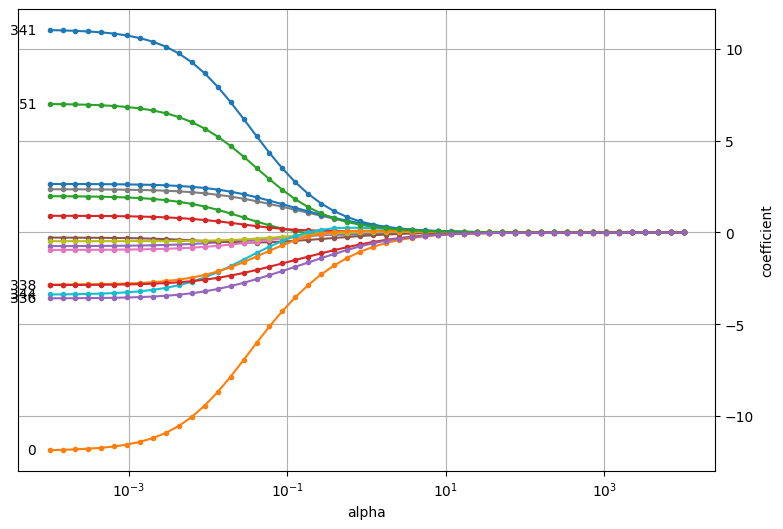

In [21]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

plot_coefficients(coefficients, n_highlight=6)

In [22]:
coxnet_pipe = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=0.01, max_iter=50, fit_baseline_model=True))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_training_trimmed, y_training_survlabel)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(X_training_trimmed, y_training_survlabel)

cv_results = pd.DataFrame(gcv.cv_results_)

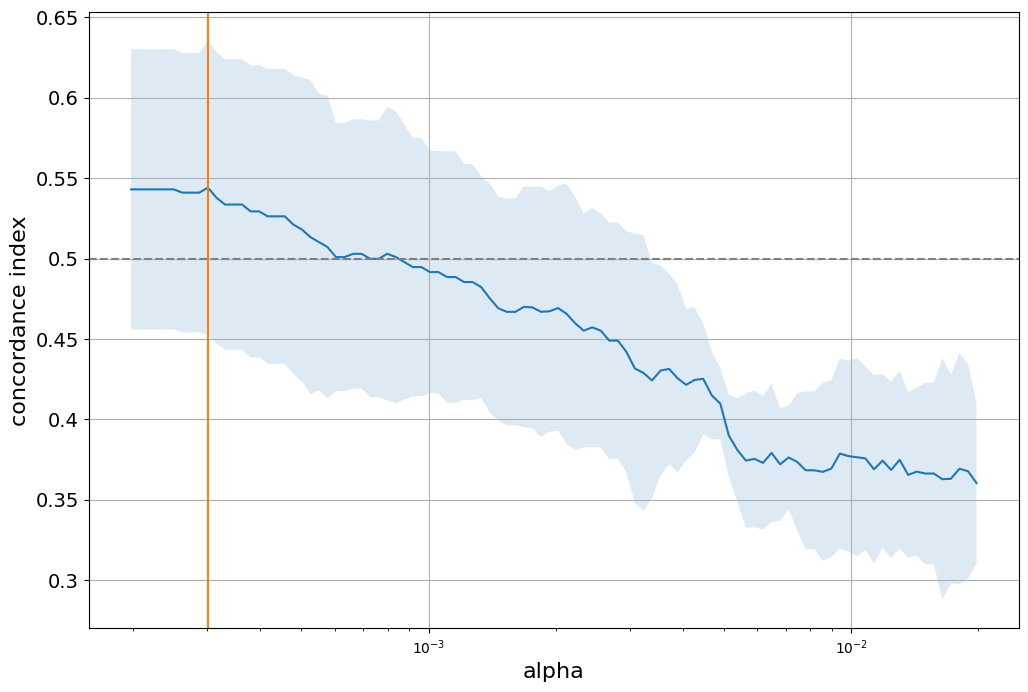

In [23]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index", fontsize=16)
ax.set_xlabel("alpha", fontsize=16)
yticks = [np.round(x,2) for x in ax.get_yticks()]
ax.set_yticklabels(yticks, fontsize=14)
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
fig.savefig(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/C_index_vs_alpha_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png')

In [24]:
X_training_trimmed

,341,0,198,115,117,1,196,137,86,344,131,327,51,338,336
0,0.135780,0.188933,0.422703,0.620270,0.511735,0.733762,0.464865,0.161430,0.203838,0.242750,0.693948,0.072199,0.113430,0.000000,0.229075
1,0.209807,0.201319,0.221687,0.563253,0.337959,0.366542,0.518072,0.001498,0.088729,0.392421,0.504755,0.000000,0.057065,0.000000,0.000000
2,0.247296,0.352508,0.511111,0.262346,0.238084,0.703239,0.530864,0.429442,0.847855,0.189848,0.487553,0.215562,0.295259,0.000000,0.094798
3,0.065157,0.036437,0.115000,0.283333,0.087658,0.070506,0.000000,0.472377,0.127178,0.184980,0.087649,0.020010,0.085591,0.000000,0.175678
4,0.345370,0.695608,0.695696,0.025353,0.286551,0.825818,0.231183,0.345368,0.075407,0.360604,0.554851,0.040978,0.061342,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.113423,0.000000,0.000000,0.766178,0.159191,0.146940,0.000000,0.271145,0.266089,0.291323,0.381005,0.002018,0.094527,0.000000,0.560093
80,0.403776,0.505640,0.552713,0.148256,0.387327,0.740523,0.833333,0.749717,0.922145,0.503645,0.537764,0.177397,0.386596,0.000000,0.192135
81,0.115206,0.141055,0.537457,0.116838,0.686807,0.878083,0.147766,0.547442,0.371400,0.272098,0.492214,0.007089,0.053745,0.000000,0.034707
82,0.070824,0.201850,0.523889,0.306944,0.706136,0.719409,0.119444,0.272741,0.604356,0.161186,0.731281,0.084144,0.098019,0.080701,0.261372


Number of non-zero coefficients: 15


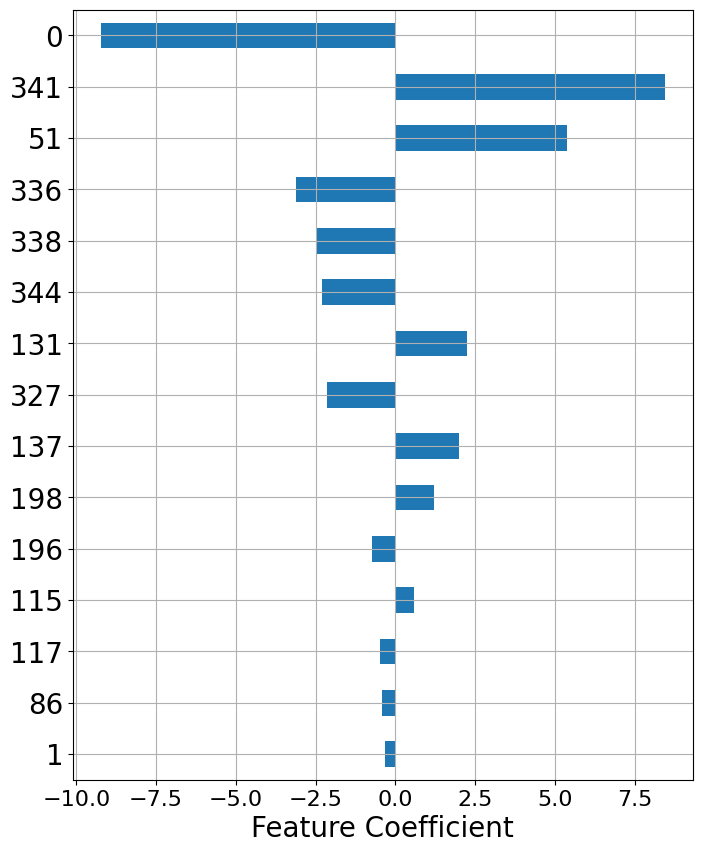

In [25]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_training_trimmed.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig1, ax = plt.subplots(figsize=(8,10))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("Feature Coefficient", fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=20)
ax.grid(True)
fig1.savefig(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/TopFeatures_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png', bbox_inches="tight")

In [26]:
non_zero_coefs.index

Index(['341', '0', '198', '115', '117', '1', '196', '137', '86', '344', '131',
       '327', '51', '338', '336'],
      dtype='object')

In [27]:
X_training_trimmed

,341,0,198,115,117,1,196,137,86,344,131,327,51,338,336
0,0.135780,0.188933,0.422703,0.620270,0.511735,0.733762,0.464865,0.161430,0.203838,0.242750,0.693948,0.072199,0.113430,0.000000,0.229075
1,0.209807,0.201319,0.221687,0.563253,0.337959,0.366542,0.518072,0.001498,0.088729,0.392421,0.504755,0.000000,0.057065,0.000000,0.000000
2,0.247296,0.352508,0.511111,0.262346,0.238084,0.703239,0.530864,0.429442,0.847855,0.189848,0.487553,0.215562,0.295259,0.000000,0.094798
3,0.065157,0.036437,0.115000,0.283333,0.087658,0.070506,0.000000,0.472377,0.127178,0.184980,0.087649,0.020010,0.085591,0.000000,0.175678
4,0.345370,0.695608,0.695696,0.025353,0.286551,0.825818,0.231183,0.345368,0.075407,0.360604,0.554851,0.040978,0.061342,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.113423,0.000000,0.000000,0.766178,0.159191,0.146940,0.000000,0.271145,0.266089,0.291323,0.381005,0.002018,0.094527,0.000000,0.560093
80,0.403776,0.505640,0.552713,0.148256,0.387327,0.740523,0.833333,0.749717,0.922145,0.503645,0.537764,0.177397,0.386596,0.000000,0.192135
81,0.115206,0.141055,0.537457,0.116838,0.686807,0.878083,0.147766,0.547442,0.371400,0.272098,0.492214,0.007089,0.053745,0.000000,0.034707
82,0.070824,0.201850,0.523889,0.306944,0.706136,0.719409,0.119444,0.272741,0.604356,0.161186,0.731281,0.084144,0.098019,0.080701,0.261372


In [28]:
X_holdout_trimmed

,341,0,198,115,117,1,196,137,86,344,131,327,51,338,336
0,0.385470,0.291013,0.280000,0.258696,0.335388,0.597698,0.000000,-0.163682,0.168009,0.377656,1.035618,0.033238,0.075837,0.000000,0.197493
1,0.000000,0.089970,0.270588,0.625000,0.928146,0.564145,0.000000,0.080844,0.547656,0.000000,0.431974,0.000000,0.000000,0.000000,0.000000
2,0.177006,0.329828,0.254386,0.351748,0.293164,0.524830,0.067398,0.223520,0.493000,0.222068,0.792239,0.171888,0.205472,0.000000,0.235945
3,0.133072,0.137316,0.000000,0.796875,0.054786,0.376293,0.000000,0.214036,0.275205,0.254935,0.536456,0.316135,0.247133,0.000000,0.000000
4,0.439271,0.543145,0.661438,0.111111,0.315111,0.793149,0.140523,0.478668,0.818047,0.698853,0.590523,0.301121,0.429520,0.181621,0.187620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.082251,0.068326,0.140816,0.542092,0.393568,0.329969,0.000000,0.236109,0.097430,0.114250,0.381953,0.005307,0.000000,0.121007,0.452912
81,0.214638,0.437739,0.547398,0.269686,0.457001,0.715737,0.166667,0.864206,0.759892,0.394020,0.468575,0.193656,0.350109,0.071497,0.228191
82,0.683180,0.750005,0.494937,0.053797,0.210824,0.887318,0.272152,-0.149635,0.599034,0.647131,1.007949,0.038082,0.083736,0.000000,0.000000
83,0.025468,0.056546,0.059943,0.769738,0.213401,0.559191,0.000000,0.066378,0.246230,0.035755,0.846792,0.092646,0.172092,0.036390,0.343318


In [29]:
non_zero_coefs.to_dict()['coefficient']

{'341': 8.445528462019997,
 '0': -9.227412734943739,
 '198': 1.2256234864815254,
 '115': 0.5761512214787377,
 '117': -0.49149291235604287,
 '1': -0.33668228401231337,
 '196': -0.7219143849971095,
 '137': 1.9972288550211472,
 '86': -0.40454716943856084,
 '344': -2.307912608176597,
 '131': 2.2439720192042127,
 '327': -2.1391369174327415,
 '51': 5.3899494251166455,
 '338': -2.445629127401445,
 '336': -3.105176221852114}

In [30]:
coef_order

Index(['1', '86', '117', '115', '196', '198', '137', '327', '131', '344',
       '338', '336', '51', '341', '0'],
      dtype='object')

In [31]:

print("Metrics for model")
coxnet_pred = gcv.best_estimator_

training_prediction = coxnet_pred.predict(X_training_trimmed)
holdout_prediction = coxnet_pred.predict(X_holdout_trimmed)

training_survival = coxnet_pred.predict_survival_function(X_training_trimmed)
times_training = np.arange(int(np.min(y_training_survlabel['time'])), int(np.max(y_training_survlabel["time"])))
try:
    survival_prediction_training = np.asarray([[fn(t) for t in times_training] for fn in training_survival])
except:
    print("Error in calculating survival prediction for training set")

holdout_survival = coxnet_pred.predict_survival_function(X_holdout_trimmed)
times_holdout = np.arange(int(np.min(y_holdout_survlabel['time'])), int(np.max(y_holdout_survlabel["time"])))
try:
    survival_prediction_holdout = np.asarray([[fn(t) for t in times_holdout] for fn in holdout_survival])
except:
    print("Error in calculating survival prediction for holdout set")

c_index_training = concordance_index_censored(y_training_survlabel["event"], y_training_survlabel["time"], training_prediction)
c_index_holdout = concordance_index_censored(y_holdout_survlabel["event"], y_holdout_survlabel["time"], holdout_prediction)
print('C-index on Training set: {:.3f}'.format(c_index_training[0]))
print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))

# calculate the IPCW C-index for the training and holdout set
c_ipcw_training = concordance_index_ipcw(y_training_survlabel, y_training_survlabel, training_prediction)
c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_survlabel, holdout_prediction)
print('IPCW C-index on Training set: {:.3f}'.format(c_ipcw_training[0]))
print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))

try:
    ibs_training = integrated_brier_score(y_training_survlabel, y_training_survlabel, survival_prediction_training, times_training)
    ibs_holdout = integrated_brier_score(y_training_survlabel, y_holdout_survlabel, survival_prediction_holdout, times_holdout)
    print('IBS on training set: {:.3f}'.format(ibs_training))
    print('IBS on Holdout set: {:.3f}'.format(ibs_holdout))
except:
    print("Error in calculating IBS")

# create a dataframe to store the model type and c-index
model_metrics = pd.DataFrame()
model_metrics['cohort'] = ["Disparity"]
model_metrics['c_index_train'] = [c_index_training[0]]
model_metrics['c_index_holdout'] = [c_index_holdout[0]]
model_metrics['c_index_ipcw_train'] = [c_ipcw_training[0]]
model_metrics['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
try:
    model_metrics['integrated_brier_score_train'] = [ibs_training]
    model_metrics['integrated_brier_score_holdout'] = [ibs_holdout]
except:
    model_metrics['integrated_brier_score_train'] = [0]
    model_metrics['integrated_brier_score_holdout'] = [0]



Metrics for model
C-index on Training set: 0.734
C-index on Holdout set: 0.583
IPCW C-index on Training set: 0.715
IPCW C-index on Holdout set: 0.587
Error in calculating IBS


In [32]:
training_risk_scores = coxnet_pred.predict(X_training_trimmed)
events, times = y_training['event'].values.astype(bool),   y_training['time'].values

coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]


# # Calculate Kaplan-Meier estimator for different risk groups
# if risk_treshold_method == "mean":
#     risk_threshold = np.mean(training_risk_scores)
# elif risk_treshold_method == "median":
#     risk_threshold = np.median(training_risk_scores)

# train_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
# train_survival_probs = []
# train_survival_times = []

# for group_label in np.unique(train_risk_group_labels):
#     group_indices = np.where(train_risk_group_labels == group_label)
#     group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
#     train_survival_probs.append(group_survival_prob)
#     train_survival_times.append(group_time)


In [33]:
min(training_risk_scores), max(training_risk_scores)

(-6.470491816909155, 3.1333602349735465)

In [34]:
mean = np.mean(training_risk_scores)
std = np.std(training_risk_scores)

# Calculate the range
lower_bound = mean - std
upper_bound = mean + std

In [35]:
len(training_risk_scores)

84

In [36]:
threshold_values = np.linspace(lower_bound, upper_bound, num=int((upper_bound - (lower_bound)) / 0.001) + 1)
p_values = []
thresholds = []

for threshold in threshold_values:
    # Assuming 'train_risk_group_labels' needs to be defined based on the current threshold
    train_risk_group_labels = np.array([1 if x > threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
    #p_values.append(multivariate_logrank_test(times, train_risk_group_labels, events).p_value)
    thresholds.append(threshold)
    p_values.append(logrank_test(times[train_risk_group_labels==0], times[train_risk_group_labels==1], events[train_risk_group_labels==0], events[train_risk_group_labels==1]).p_value)



In [37]:
# from lifelines import KaplanMeierFitter, CoxPHFitter

# # Convert times and events to structured array expected by sksurv
# data_structured = np.array([(event, time) for event, time in zip(events, times)], 
#                            dtype=[('event', bool), ('time', float)])

# data_structured = pd.DataFrame(data_structured, columns=['event', 'time'])
# data_structured['risk_score'] = training_risk_scores

# threshold_diffs = []

# def kaplan_meier_estimator(events, times):
#     kmf = KaplanMeierFitter()
#     kmf.fit(durations=times, event_observed=events)
#     return kmf.survival_function_.index.values, kmf.survival_function_['KM_estimate'].values

# # First pass: Calculate differences in median survival times for all thresholds
# for threshold in threshold_values:
#     high_risk_data = data_structured[data_structured['risk_score'] > threshold]
#     low_risk_data = data_structured[data_structured['risk_score'] <= threshold]

#     time_high, survival_prob_high = kaplan_meier_estimator(high_risk_data['event'], high_risk_data['time'])
#     time_low, survival_prob_low = kaplan_meier_estimator(low_risk_data['event'], low_risk_data['time'])

#     median_high_risk = np.median(time_high[survival_prob_high >= 0.5])
#     median_low_risk = np.median(time_low[survival_prob_low >= 0.5])

#     diff = np.abs(median_high_risk - median_low_risk)
#     threshold_diffs.append((threshold, diff))

# # Sort the thresholds by their differences and take the top 5
# top_5_thresholds = sorted(threshold_diffs, key=lambda x: x[1], reverse=True)[:5]

# # Second pass: For the top 5 thresholds, calculate HR and select the one with the largest HR
# max_hr = 0
# optimal_threshold = None

# for threshold, _ in top_5_thresholds:
#     data_structured['risk_group'] = np.where(data_structured['risk_score'] > threshold, 1, 0)  # Use 1 for high risk, 0 for low risk
#     cph = CoxPHFitter()
#     cph.fit(data_structured[['time', 'event', 'risk_group']], 'time', 'event')
#     hr = cph.hazard_ratios_['risk_group']  # Adjust based on actual results and variable names

#     if hr > max_hr:
#         max_hr = hr
#         optimal_threshold = threshold

# # Output the optimal threshold
# print("Optimal Threshold:", optimal_threshold)
# print("Largest Hazard Ratio:", max_hr)

In [38]:
risk_threshold = np.median(training_risk_scores)
#risk_threshold = optimal_threshold

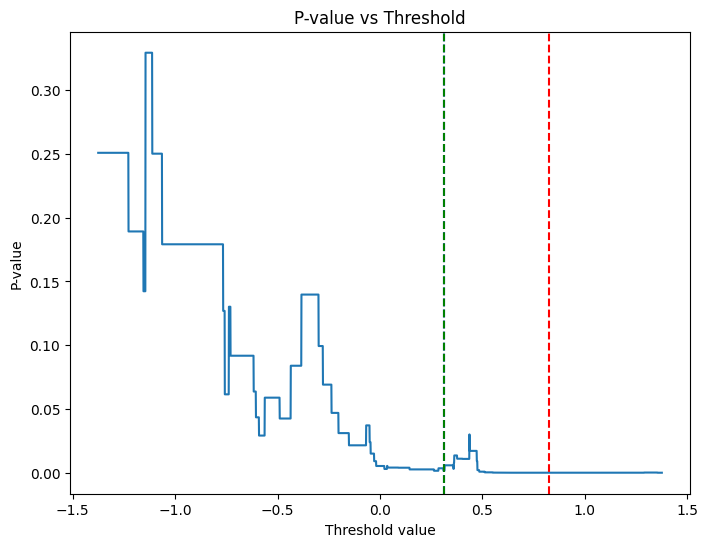

In [39]:
# plot p values vs thresholds
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, p_values)
ax.set_xlabel("Threshold value")
ax.set_ylabel("P-value")
ax.set_title("P-value vs Threshold")
#plot a red line in the minimum p-value
min_pval_idx = np.argmin(p_values)
ax.axvline(risk_threshold, color='blue', linestyle='--')
ax.axvline(thresholds[min_pval_idx], color='r', linestyle='--')
ax.axvline(np.median(training_risk_scores), color='g', linestyle='--')

In [40]:
train_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in training_risk_scores])#np.digitize(train_risk_scores, risk_groups)
train_survival_probs = []
train_survival_times = []

for group_label in np.unique(train_risk_group_labels):
    group_indices = np.where(train_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    train_survival_probs.append(group_survival_prob)
    train_survival_times.append(group_time)


In [41]:

holdout_risk_scores = coxnet_pred.predict(X_holdout_trimmed)
events, times = y_holdout['event'].values.astype(bool),   y_holdout['time'].values

coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]


# Calculate Kaplan-Meier estimator for different risk groups

holdout_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_risk_scores])#np.digitize(test_risk_scores, risk_groups)
holdout_survival_probs = []
holdout_survival_times = []

for group_label in np.unique(holdout_risk_group_labels):
    group_indices = np.where(holdout_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(events[group_indices], times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)



In [42]:

results = logrank_test(times[holdout_risk_group_labels==0], times[holdout_risk_group_labels==1], events[holdout_risk_group_labels==0], events[holdout_risk_group_labels==1])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.73 0.03      5.07

In [43]:

results = multivariate_logrank_test(times, holdout_risk_group_labels, events)
results.p_value

0.029703675950069165

In [44]:
y_holdout['risk_score'] = holdout_risk_scores
y_holdout['risk_group'] = holdout_risk_group_labels
y_holdout['patient_id'] = y_holdout['patient_id']
y_holdout = y_holdout.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout

,patient_id,event,time,risk_score,risk_group
0,0521-011235,0,10.736986,-0.309431,0
1,0521-029609,0,11.534247,1.338371,1
2,0521-031663,0,9.978082,-1.123451,0
3,0521-032790,1,2.810959,-0.000013,0
4,0521-042494,0,12.550685,-1.619637,0
...,...,...,...,...,...
80,0521-930935,0,12.698630,1.948705,1
81,0521-931689,0,12.468493,-0.405241,0
82,0521-948904,0,4.200000,0.280972,0
83,0521-968370,0,12.610959,0.493726,1


In [45]:
y_training['risk_score'] = training_risk_scores
y_training['risk_group'] = train_risk_group_labels
y_training['patient_id'] = y_training['patient_id']
y_training = y_training.sort_values(by=['patient_id']).reset_index(drop=True)
y_training

,patient_id,event,time,risk_score,risk_group
0,0521-002001,0,7.111790,0.825448,1
1,0521-035384,0,9.703099,-0.490480,0
2,0521-039456,1,1.936986,0.314677,1
3,0521-042918,0,10.649001,-0.202927,0
4,0521-046445,0,6.528767,1.054589,1
...,...,...,...,...,...
79,0521-934543,1,3.413699,2.178890,1
80,0521-966640,1,3.983562,1.997473,1
81,0521-983798,0,10.441680,-3.206356,0
82,0521-989175,0,10.780844,0.549811,1


In [46]:
y_holdout.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/holdout_survival_risk_scores_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}_top_1.csv', index=False)
y_training.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/training_survival_risk_scores_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}_top_1.csv', index=False)

In [47]:
from lifelines import CoxPHFitter

LL_train = y_training.drop(['patient_id', 'risk_score'], axis=1)
LL_holdout = y_holdout.drop(['patient_id', 'risk_score'], axis=1)
cph_train = CoxPHFitter()
cph_train.fit(LL_train, duration_col='time', event_col='event', show_progress=False)

cph_holdout = CoxPHFitter()
cph_holdout.fit(LL_holdout, duration_col='time', event_col='event', show_progress=False)


training_results = cph_train.summary
training_p = multivariate_logrank_test(y_training['time'], y_training['risk_group'], y_training['event']).p_value# training_results['p'].values[0]
training_hr = training_results['exp(coef)'].values[0]
training_ci_lower = training_results['exp(coef) lower 95%'].values[0]
training_ci_upper = training_results['exp(coef) upper 95%'].values[0]
training_log_likelihood = cph_train.log_likelihood_
model_metrics['training_p_value'] = [training_p]
model_metrics['training_hazard_ratio'] = [training_hr]
model_metrics['training_hr_ci_lower'] = [training_ci_lower]
model_metrics['training_hr_ci_upper'] = [training_ci_upper]
model_metrics['training_log_likelihood'] = [training_log_likelihood]
model_metrics['training_parameters'] = [cph_train.params_.shape[0]]

training_data_stats = (training_p, training_hr, training_ci_lower, training_ci_upper)


holdout_results = cph_holdout.summary
holdout_p = multivariate_logrank_test(y_holdout['time'], y_holdout['risk_group'], y_holdout['event']).p_value # holdout_results['p'].values[0]
holdout_hr = holdout_results['exp(coef)'].values[0]
holdout_ci_lower = holdout_results['exp(coef) lower 95%'].values[0]
holdout_ci_upper = holdout_results['exp(coef) upper 95%'].values[0]
holdout_log_likelihood = cph_holdout.log_likelihood_
model_metrics['holdout_p_value'] = [holdout_p]
model_metrics['holdout_hazard_ratio'] = [holdout_hr]
model_metrics['holdout_hr_ci_lower'] = [holdout_ci_lower]
model_metrics['holdout_hr_ci_upper'] = [holdout_ci_upper]
model_metrics['holdout_log_likelihood'] = [holdout_log_likelihood]
model_metrics['holdout_parameters'] = [cph_holdout.params_.shape[0]]

holdout_data_stats = (holdout_p, holdout_hr, holdout_ci_lower, holdout_ci_upper)




In [48]:
cph_holdout.score(LL_holdout, scoring_method='log_likelihood')

-1.35253848406397

In [49]:
cph_train.print_summary()

<lifelines.CoxPHFitter: fitted with 84 total observations, 55 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 84
number of events observed = 29
   partial log-likelihood = -114.71
         time fit was run = 2024-04-24 15:31:58 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   1.19       3.29       0.40             0.40             1.98                 1.49                 7.25

             cmp to    z      p   -log2(p)
covariate                                 
risk_group     0.00 2.95 <0.005       8.31
---
Concordance = 0.67
Partial AIC = 231.43
log-likelihood ratio test = 9.59 on 1 df
-log2(p) of ll-ratio test = 9.00

In [50]:
cph_holdout.print_summary()

<lifelines.CoxPHFitter: fitted with 85 total observations, 56 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 29
   partial log-likelihood = -114.97
         time fit was run = 2024-04-24 15:31:58 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.83       2.29       0.39             0.06             1.60                 1.06                 4.95

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 2.11 0.03       4.86
---
Concordance = 0.59
Partial AIC = 231.93
log-likelihood ratio test = 4.74 on 1 df
-log2(p) of ll-ratio test = 5.08

In [51]:
LL_holdout

,event,time,risk_group
0,0,10.736986,0
1,0,11.534247,1
2,0,9.978082,0
3,1,2.810959,0
4,0,12.550685,0
...,...,...,...
80,0,12.698630,1
81,0,12.468493,0
82,0,4.200000,0
83,0,12.610959,1


In [52]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import seaborn as sns

def plot_km_curve_lifelines(data_df, data_stats, figure_save_path, title_str):
    
    # Create a colormap
    cmap = plt.cm.get_cmap('Reds')
    # Choose a shade of red
    hr_shade = cmap(0.75)

    cmap = plt.cm.get_cmap('Blues')
    # Choose a shade of red
    lr_shade = cmap(0.75)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    data_high_risk = data_df[data_df['risk_group']==1]
    data_low_risk = data_df[data_df['risk_group']==0]

    kmf_hr = KaplanMeierFitter()
    kmf_hr.fit(data_high_risk['time'], event_observed=data_high_risk['event'], label='High Risk')
    kmf_hr.plot_survival_function(ax=ax, color='#f8766d', lw=2, show_censors=True)

    kmf_lr = KaplanMeierFitter()
    kmf_lr.fit(data_low_risk['time'], event_observed=data_low_risk['event'], label='Low Risk')
    kmf_lr.plot_survival_function(ax=ax, color='#03bfc4', lw=2, show_censors=True, )
    
    
    print("Low risk median survival time: ",kmf_lr.median_survival_time_)
    print("High risk median survival time: ",kmf_hr.median_survival_time_)
    max_median_survival_time = max(kmf_hr.median_survival_time_ , kmf_lr.median_survival_time_)
    if max_median_survival_time == np.inf:
        plt.axhline(y=0.5, color='black', linestyle='--', lw=1)
    else:
        plt.plot([0, max_median_survival_time], [0.5, 0.5], color='black', linestyle='--', lw=1)
    # Vertical lines up to y=0.5, using plot for precise control
    plt.plot([kmf_hr.median_survival_time_, kmf_hr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    plt.plot([kmf_lr.median_survival_time_, kmf_lr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    ax.set_title(title_str, fontsize=26)

    yticks = [np.round(x,1) for x in ax.get_yticks()]
    ax.set_yticklabels(yticks, fontsize=20)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)


    ax.set_xlabel('Time (Years)', fontsize=28)
    ax.set_ylabel('BCR-free Survival Probability', fontsize=28)
    data_p, data_hr, data_ci_lower, data_ci_upper = data_stats
    format_p = lambda p: f"{p:.1e}" if p < 0.001 else f"{p:.4f}"

# Updated string formatting
    data_stats_text = f'p: {format_p(data_p)}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    #data_stats_text = f'p: {data_p:.1e if data_p < 0.001 else data_p:.4f}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    ax.text(0.03, 0.1, data_stats_text, transform=ax.transAxes, fontsize=24, verticalalignment='bottom')

    # Add the risk table at the bottom of the KM plot on ax[1] (the bottom subplot)
    sns.despine()
    add_at_risk_counts(kmf_hr, kmf_lr, ax=ax, fontsize=20)
    ax.legend(fontsize=24)
    plt.tight_layout()
    
    fig.savefig(figure_save_path, bbox_inches='tight')
    plt.show()





/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2035154765.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2035154765.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  9.854794521


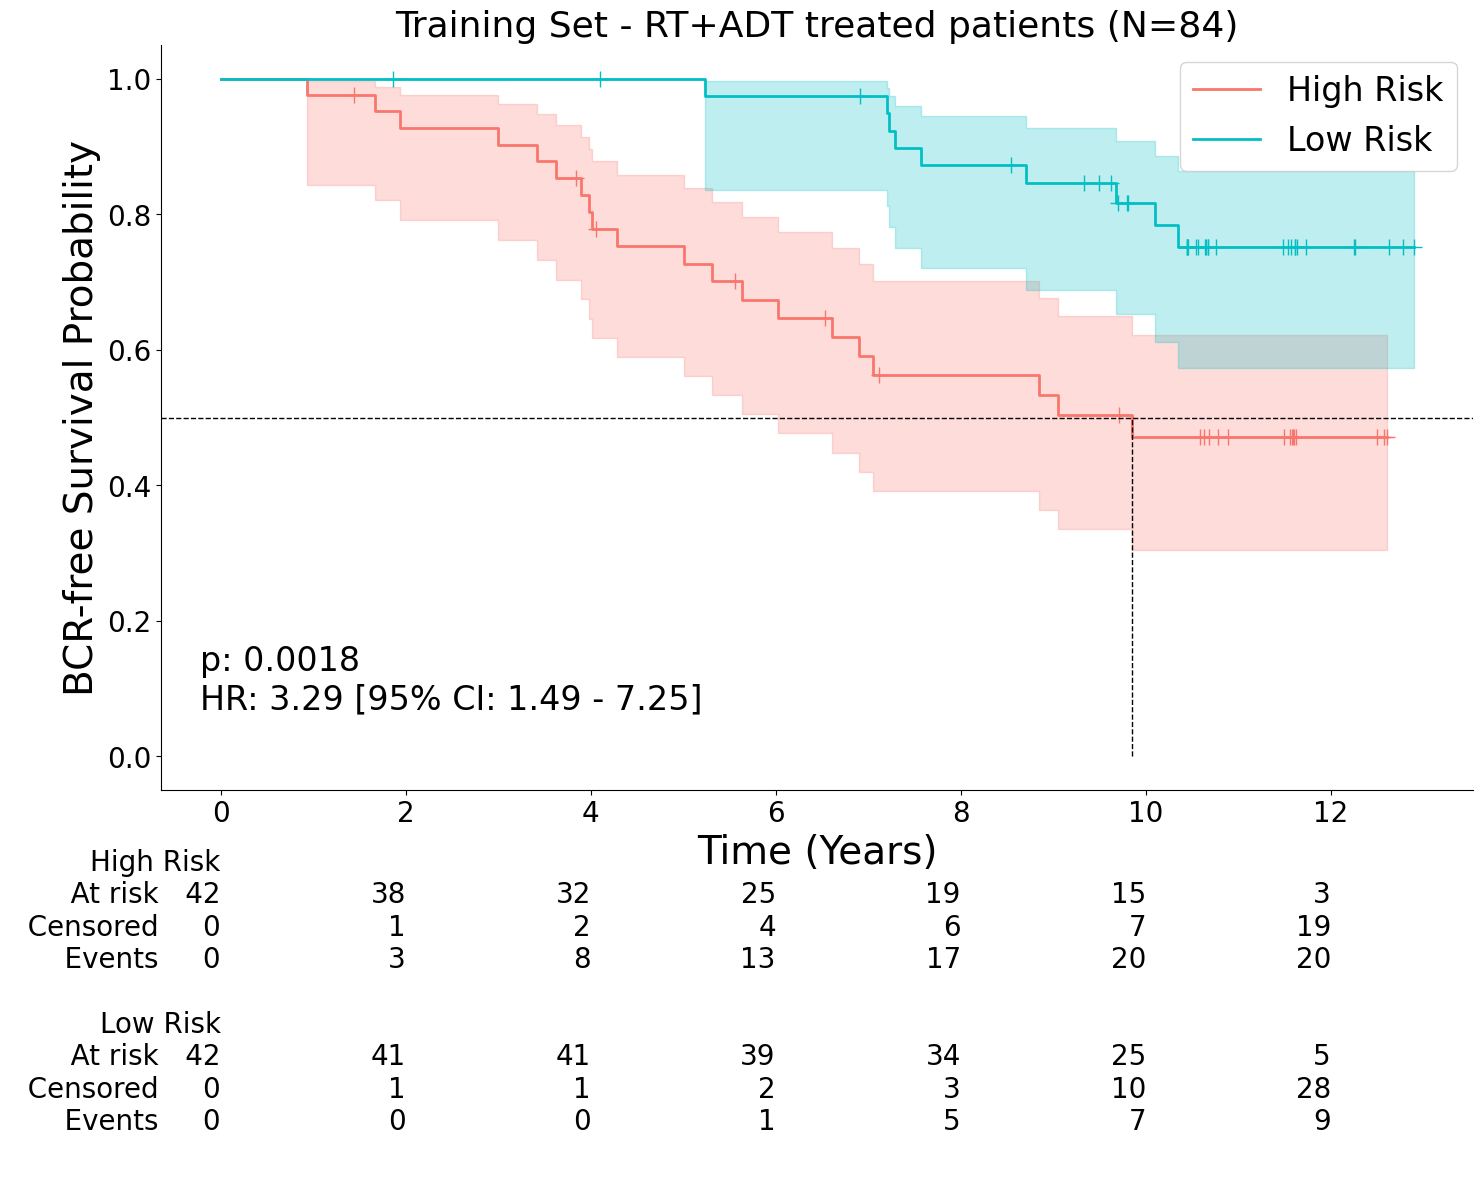

In [53]:
train_title_str = 'Training Set - RT+ADT treated patients (N={:d})'.format(len(y_training))
train_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_training_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_training, training_data_stats, train_figure_save_path, train_title_str)

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2035154765.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2035154765.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  10.83835616


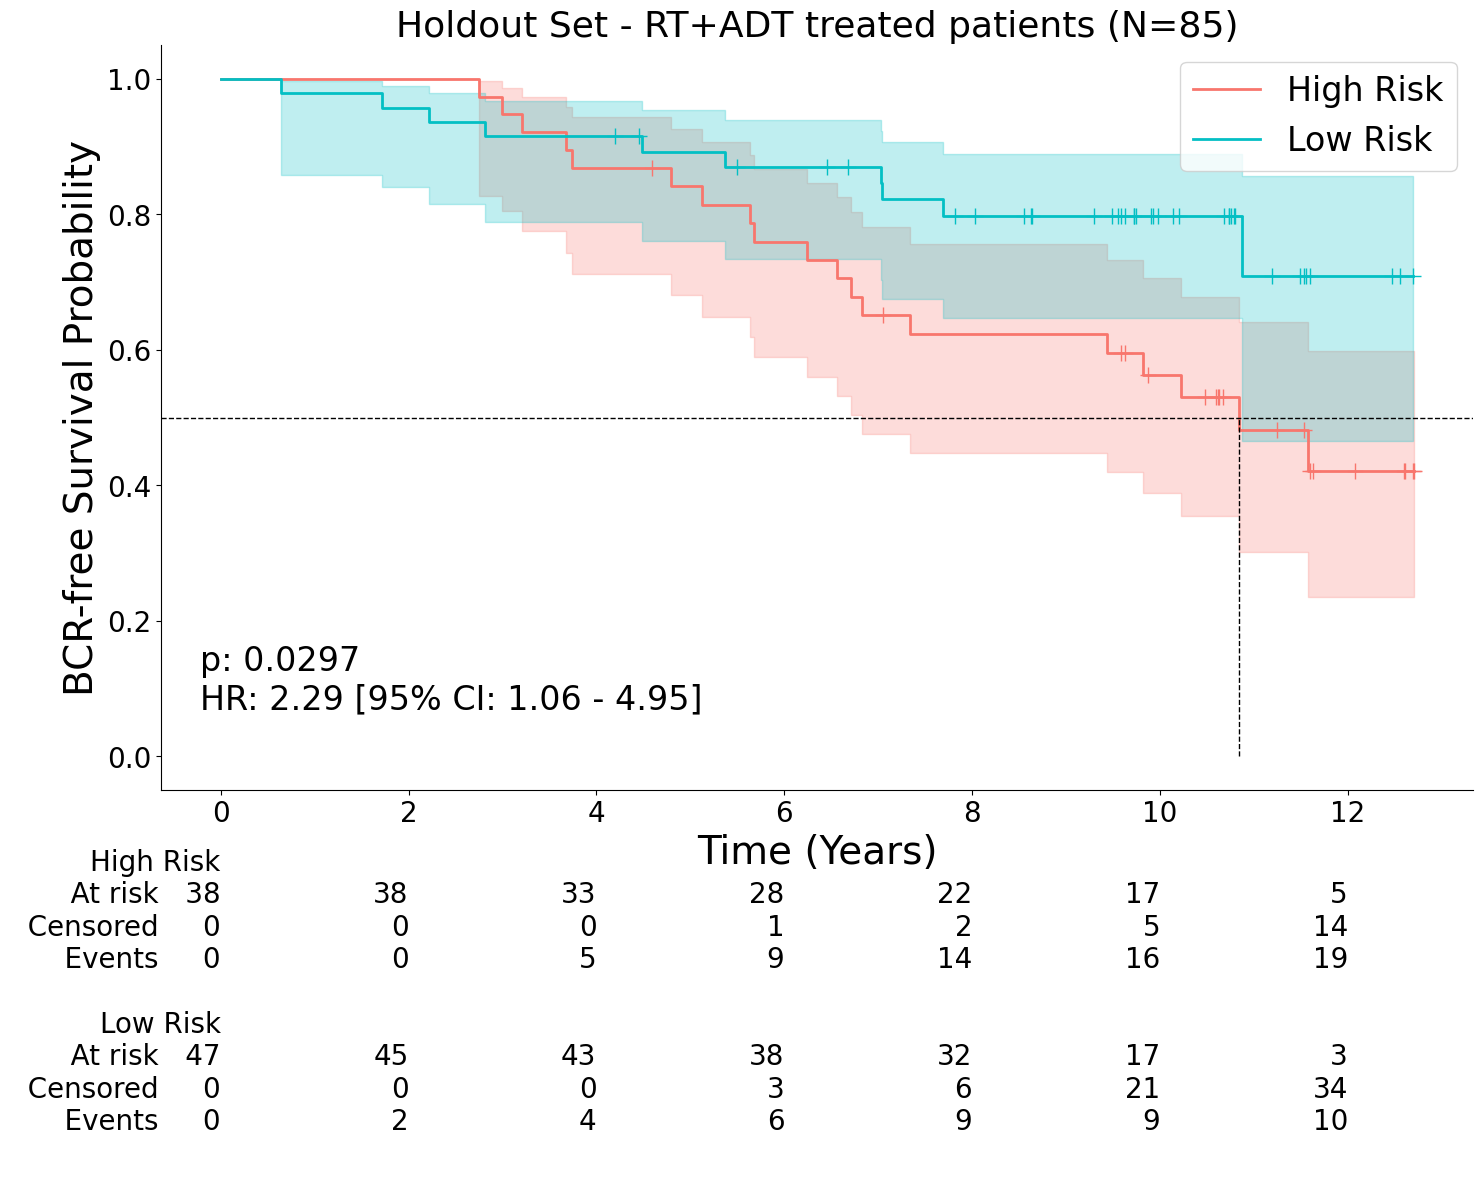

In [54]:
# plot the KM curve for the holdout data

holdout_title_str = 'Holdout Set - RT+ADT treated patients (N={:d})'.format(len(y_holdout))
holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_{cohort}.png'
plot_km_curve_lifelines(y_holdout, holdout_data_stats, holdout_figure_save_path, holdout_title_str)

### Checking selected feature distributions

341


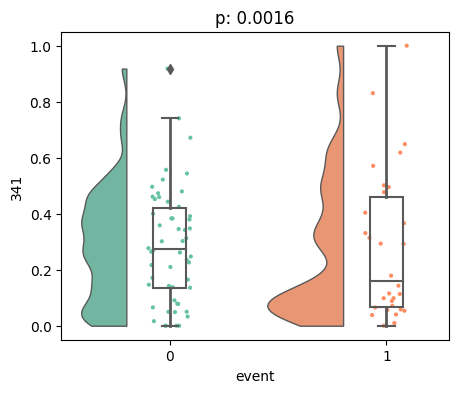

0


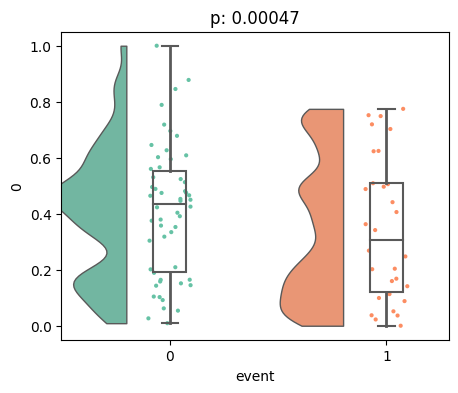

198


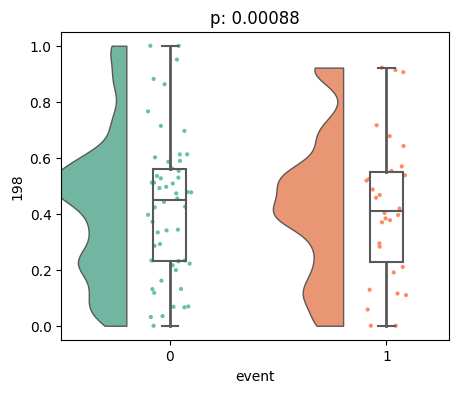

115


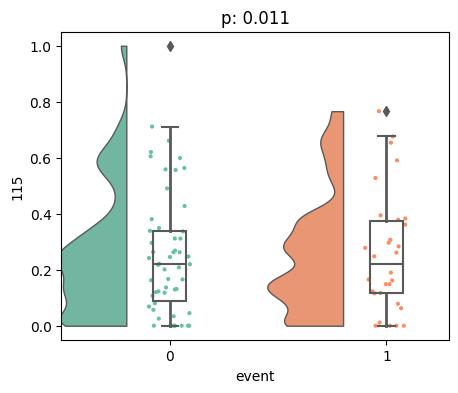

117


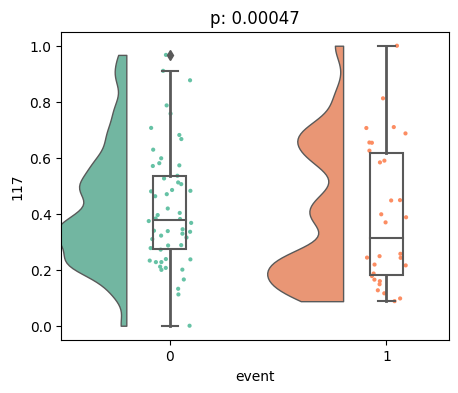

1


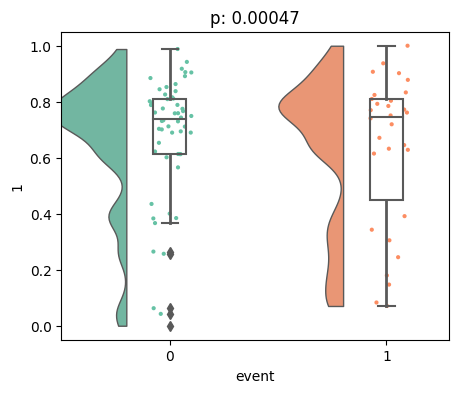

196


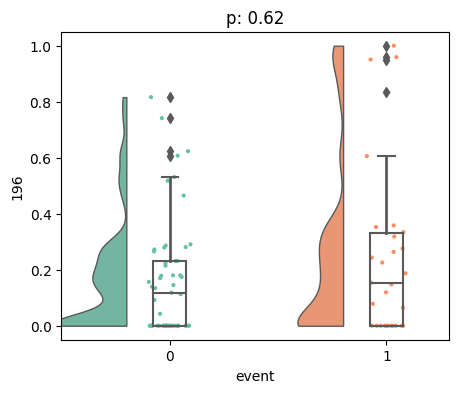

137


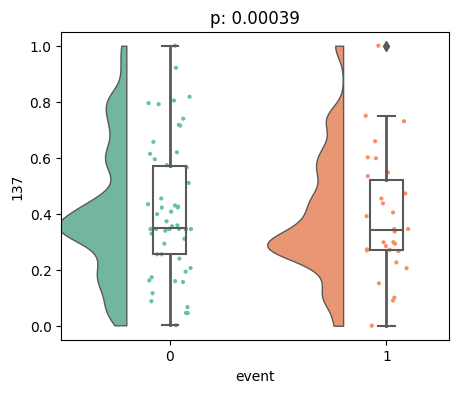

86


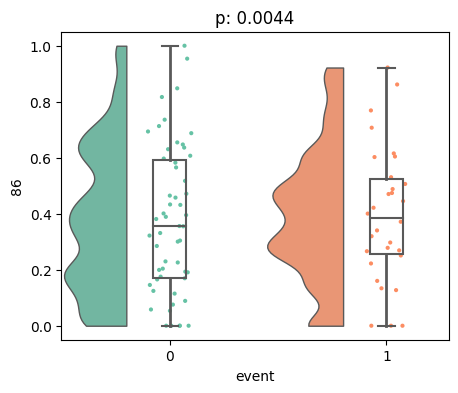

344


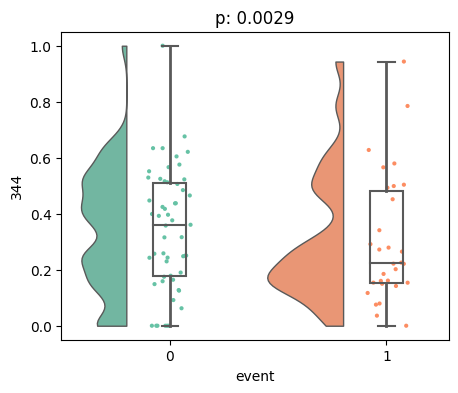

131


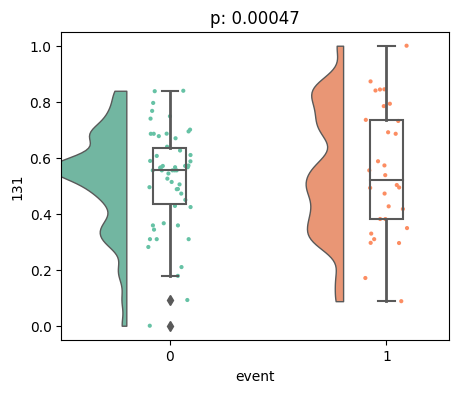

327


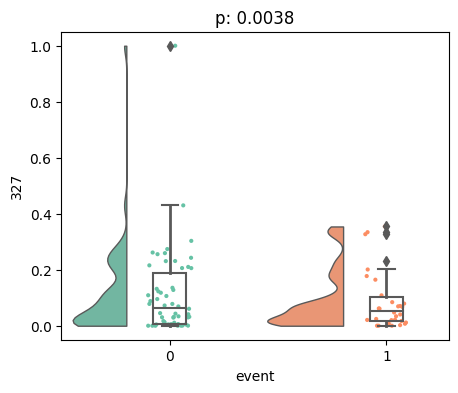

51


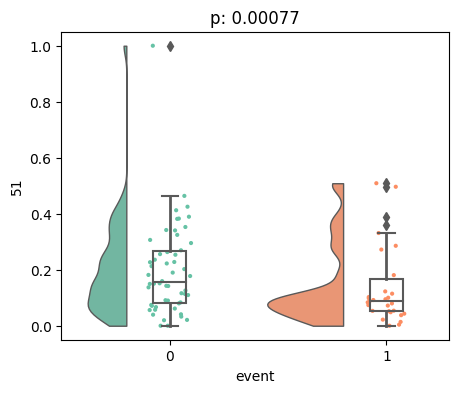

338


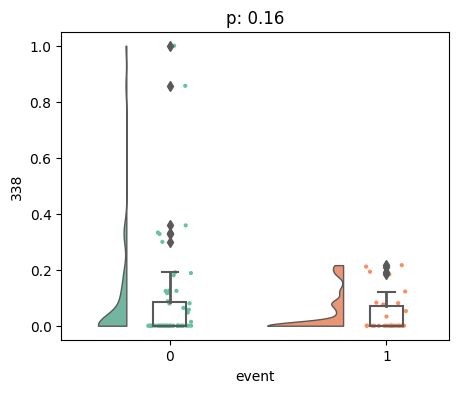

336


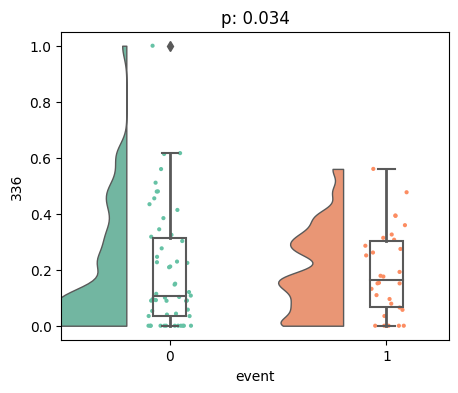

In [55]:
for i, feature in enumerate(X_training_trimmed):
    pvalue = mannwhitneyu(X_training_trimmed[feature], y_training['event']).pvalue
    print(feature)
    plt.figure(figsize=(5,4))
    pt.RainCloud(x=rtog_features['event'], y=X_training_trimmed[feature])
    plt.title(f'p: {pvalue:.2}')
    plt.show()

## Test on treatment group

In [56]:
rtog_leg_2 = rtog_features.loc[rtog_features['RX'] == 2]

In [102]:
rtog_leg_2['event'].value_counts()

event
0    128
1     53
Name: count, dtype: int64

In [57]:
rtog_leg_2

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,patient_id,RX,time,event
0,2.313596,616639.821685,519807.230097,253030.706008,508293.281534,600273.001790,455779.993811,1.403957,0.340978,0.002819,...,0.000197,0.000116,0.000437,0.000014,1.427801,0.304765,0521-237186,2,12.569863,0
1,0.589928,505414.643734,422261.633692,166007.268837,408408.112421,488887.852076,373262.884875,1.587910,0.446749,0.005703,...,0.000055,0.000039,0.000115,0.000000,1.595238,0.445435,0521-972417,2,12.673973,0
5,0.396189,480941.179183,345490.595895,198424.747513,327536.987454,452869.594011,266844.371610,1.685679,0.488377,0.004891,...,0.000021,0.000061,0.000088,0.000044,1.457733,0.263291,0521-225072,2,6.144105,1
6,0.268107,184335.822454,105471.102943,72672.213230,90057.251991,165984.686675,69159.879317,1.306665,0.403531,0.008678,...,0.000012,0.000028,0.000035,0.000009,1.457733,0.263291,0521-356209,2,12.649315,0
8,1.478261,648282.241686,492557.526850,387260.660437,477086.938091,635982.417572,367576.736011,1.172498,0.190390,0.001971,...,0.000147,0.000249,0.000364,0.000060,1.233333,-0.201193,0521-898902,2,12.876712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3.785388,763110.284976,680244.692178,316319.072748,670525.273779,748916.141023,625436.513089,1.442986,0.344349,0.002164,...,0.000285,0.000102,0.000643,0.000000,1.677619,0.582346,0521-099200,2,9.506849,0
338,3.925926,761307.474713,720179.075886,390970.856051,719748.965138,757093.776509,683685.421087,1.150365,0.034831,0.001614,...,0.000296,0.000099,0.000650,0.000000,1.538267,0.472338,0521-798508,2,9.632877,0
342,0.626168,168678.557827,104747.998678,59539.249599,91805.568627,154588.187894,73913.414137,1.182991,0.322650,0.006772,...,0.000033,0.000047,0.000094,0.000000,1.999942,0.000000,0521-506251,2,9.317808,0
346,3.107306,742567.916680,653911.581944,299697.746032,644335.005238,727159.392769,596918.918362,1.564805,0.406043,0.001126,...,0.000212,0.000144,0.000476,0.000027,1.490400,0.354955,0521-227777,2,9.731507,0


In [58]:
X_holdout_decipher = rtog_leg_2.drop(['patient_id', 'event', 'time'], axis=1).reset_index(drop=True)
y_holdout_decipher = rtog_leg_2[['patient_id','event', 'time']].reset_index(drop=True)
X_holdout_decipher = pd.DataFrame(scaler.transform(X_holdout_decipher), columns=X_holdout_decipher.columns)
X_holdout_decipher_trimmed = X_holdout_decipher[X_training_trimmed.columns]

In [59]:
y_holdout_decipher_survlabel = Surv.from_dataframe('event', 'time', y_holdout_decipher)

In [60]:
X_holdout_decipher_trimmed

,341,0,198,115,117,1,196,137,86,344,131,327,51,338,336
0,0.379184,0.414194,0.333775,0.327203,0.279487,0.683568,0.053050,0.291131,0.340000,0.346534,0.540893,0.303286,3.213796e-01,0.060227,0.171642
1,0.092074,0.050906,0.079195,0.519784,0.286871,0.531910,0.000000,0.122412,0.263246,0.116894,0.845072,0.036772,3.321360e-01,0.000000,0.104711
2,0.069949,0.010072,0.064864,0.817275,0.216229,0.498540,0.189644,0.050950,0.229514,0.182838,0.965371,0.147670,6.629564e-02,0.025909,0.231578
3,0.027806,-0.016923,-0.003487,0.640634,0.149176,0.094110,0.000000,0.246856,0.182669,0.082881,0.334109,0.135999,2.974719e-02,0.032017,0.313808
4,0.290616,0.238135,0.628815,0.184783,0.866848,0.726713,0.000000,0.336043,0.093023,0.741689,0.367936,0.000000,1.695245e-01,0.000000,0.104673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.532163,0.724396,0.630027,0.029110,0.268978,0.883285,0.000000,0.809754,0.660462,0.303495,0.508447,0.514530,6.720936e-01,0.000000,0.088862
177,0.519415,0.754017,0.436116,0.039352,0.218171,0.880826,0.000000,0.329023,0.285714,0.293632,0.572710,0.028321,2.240124e-01,0.000000,0.000000
178,0.075143,0.058544,0.075583,0.714953,0.321846,0.072761,0.418949,0.411134,0.408745,0.140116,0.325359,0.524300,1.307799e-01,0.245734,0.222055
179,0.409332,0.581481,0.451604,0.116438,0.335188,0.855274,0.307038,0.436559,0.543339,0.428515,0.651718,0.939229,7.623345e-01,0.000000,0.037963


In [61]:
holdout_decipher_risk_scores = coxnet_pred.predict(X_holdout_decipher_trimmed)

In [62]:
decipher_events, decipher_times = y_holdout_decipher['event'].values.astype(bool), y_holdout_decipher['time'].values
coxnet_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

holdout_decipher_risk_group_labels = np.array([1 if x > risk_threshold else 0 for x in holdout_decipher_risk_scores])
holdout_decipher_survival_probs = []
holdout_decipher_survival_times = []

for group_label in np.unique(holdout_decipher_risk_group_labels):
    group_indices = np.where(holdout_decipher_risk_group_labels == group_label)
    group_time, group_survival_prob = kaplan_meier_estimator(decipher_events[group_indices], decipher_times[group_indices])
    holdout_survival_probs.append(group_survival_prob)
    holdout_survival_times.append(group_time)


In [63]:
results = logrank_test(decipher_times[holdout_decipher_risk_group_labels==0], decipher_times[holdout_decipher_risk_group_labels==1], decipher_events[holdout_decipher_risk_group_labels==0], decipher_events[holdout_decipher_risk_group_labels==1])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.89      0.17

In [64]:
decipher_results = multivariate_logrank_test(decipher_times, holdout_decipher_risk_group_labels, decipher_events)
decipher_results.p_value

0.8909985173428114

In [65]:
y_holdout_decipher['risk_score'] = holdout_decipher_risk_scores
y_holdout_decipher['risk_group'] = holdout_decipher_risk_group_labels
y_holdout_decipher['patient_id'] = y_holdout_decipher['patient_id']
y_holdout_decipher = y_holdout_decipher.sort_values(by=['patient_id']).reset_index(drop=True)
y_holdout_decipher

,patient_id,event,time,risk_score,risk_group
0,0521-024492,0,9.430781,3.413564,1
1,0521-031363,0,10.636477,0.795337,1
2,0521-034934,0,9.490411,-0.567792,0
3,0521-039475,0,5.018340,0.449857,1
4,0521-044097,0,9.536986,0.747756,1
...,...,...,...,...,...
176,0521-972417,0,12.673973,3.544739,1
177,0521-979111,0,4.619178,1.515082,1
178,0521-979162,0,12.649315,1.915979,1
179,0521-998850,0,10.612606,-0.129646,0


In [66]:
y_holdout_decipher.to_csv(f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/leg2_holdout_survival_risk_scores_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}_top_1.csv', index=False)

In [67]:
print("Metrics for RTOG treatment leg cohort")
coxnet_pred = gcv.best_estimator_

decipher_holdout_prediction = coxnet_pred.predict(X_holdout_decipher_trimmed)

decipher_holdout_survival = coxnet_pred.predict_survival_function(X_holdout_decipher_trimmed)
times_holdout_decipher = np.arange(int(np.min(y_holdout_decipher_survlabel['time'])), int(np.max(y_holdout_decipher_survlabel["time"])))
survival_prediction_holdout_decipher = np.asarray([[fn(t) for t in times_holdout_decipher] for fn in decipher_holdout_survival])

c_index_holdout = concordance_index_censored(y_holdout_decipher_survlabel["event"], y_holdout_decipher_survlabel["time"], decipher_holdout_prediction)
print('C-index on Holdout set: {:.3f}'.format(c_index_holdout[0]))

c_ipcw_holdout = concordance_index_ipcw(y_training_survlabel, y_holdout_decipher_survlabel, decipher_holdout_prediction)
print('IPCW C-index on Holdout set: {:.3f}'.format(c_ipcw_holdout[0]))

# ibs_holdout = integrated_brier_score(y_training_survlabel, y_holdout_decipher_survlabel, survival_prediction_holdout_decipher, times_holdout_decipher)
# print('IBS on Holdout set: {:.3f}'.format(ibs_holdout))

# create a dataframe to store the model type and c-index
model_metrics_decipher = pd.DataFrame()
model_metrics_decipher['cohort'] = ["Decipher"]
model_metrics_decipher['c_index_holdout'] = [c_index_holdout[0]]
model_metrics_decipher['c_index_ipcw_holdout'] = [c_ipcw_holdout[0]]
model_metrics_decipher['integrated_brier_score_holdout'] = [0]

Metrics for RTOG treatment leg cohort
C-index on Holdout set: 0.489
IPCW C-index on Holdout set: 0.544


In [68]:

LL_holdout_decipher = y_holdout_decipher.drop(['patient_id', 'risk_score'], axis=1)
cph_holdout_decipher = CoxPHFitter()
cph_holdout_decipher.fit(LL_holdout_decipher, duration_col='time', event_col='event', show_progress=False)

decipher_holdout_results = cph_holdout_decipher.summary
decipher_holdout_p = multivariate_logrank_test(y_holdout_decipher['time'], y_holdout_decipher['risk_group'], y_holdout_decipher['event']).p_value # holdout_results['p'].values[0]
decipher_holdout_hr = decipher_holdout_results['exp(coef)'].values[0]
decipher_holdout_ci_lower = decipher_holdout_results['exp(coef) lower 95%'].values[0]
decipher_holdout_ci_upper = decipher_holdout_results['exp(coef) upper 95%'].values[0]
decipher_holdout_log_likelihood = cph_holdout_decipher.log_likelihood_
model_metrics_decipher['holdout_p_value'] = [decipher_holdout_p]
model_metrics_decipher['holdout_hazard_ratio'] = [decipher_holdout_hr]
model_metrics_decipher['holdout_hr_ci_lower'] = [decipher_holdout_ci_lower]
model_metrics_decipher['holdout_hr_ci_upper'] = [decipher_holdout_ci_upper]
model_metrics_decipher['holdout_log_likelihood'] = [decipher_holdout_log_likelihood]
model_metrics_decipher['holdout_parameters'] = [cph_holdout_decipher.params_.shape[0]]

decipher_holdout_data_stats = (decipher_holdout_p, decipher_holdout_hr, decipher_holdout_ci_lower, decipher_holdout_ci_upper)

In [69]:
cph_holdout_decipher.score(LL_holdout, scoring_method='log_likelihood')

-1.3774174151345449

In [70]:
cph_holdout_decipher.print_summary()

<lifelines.CoxPHFitter: fitted with 181 total observations, 128 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 181
number of events observed = 53
   partial log-likelihood = -249.80
         time fit was run = 2024-04-24 15:32:01 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_group   0.05       1.05       0.33            -0.60             0.69                 0.55                 2.00

             cmp to    z    p   -log2(p)
covariate                               
risk_group     0.00 0.14 0.89       0.17
---
Concordance = 0.49
Partial AIC = 501.60
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.17

In [71]:
LL_holdout_decipher

,event,time,risk_group
0,0,9.430781,1
1,0,10.636477,1
2,0,9.490411,0
3,0,5.018340,1
4,0,9.536986,1
...,...,...,...
176,0,12.673973,1
177,0,4.619178,1
178,0,12.649315,1
179,0,10.612606,0


Low risk median survival time:  inf
High risk median survival time:  inf


/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2035154765.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2035154765.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


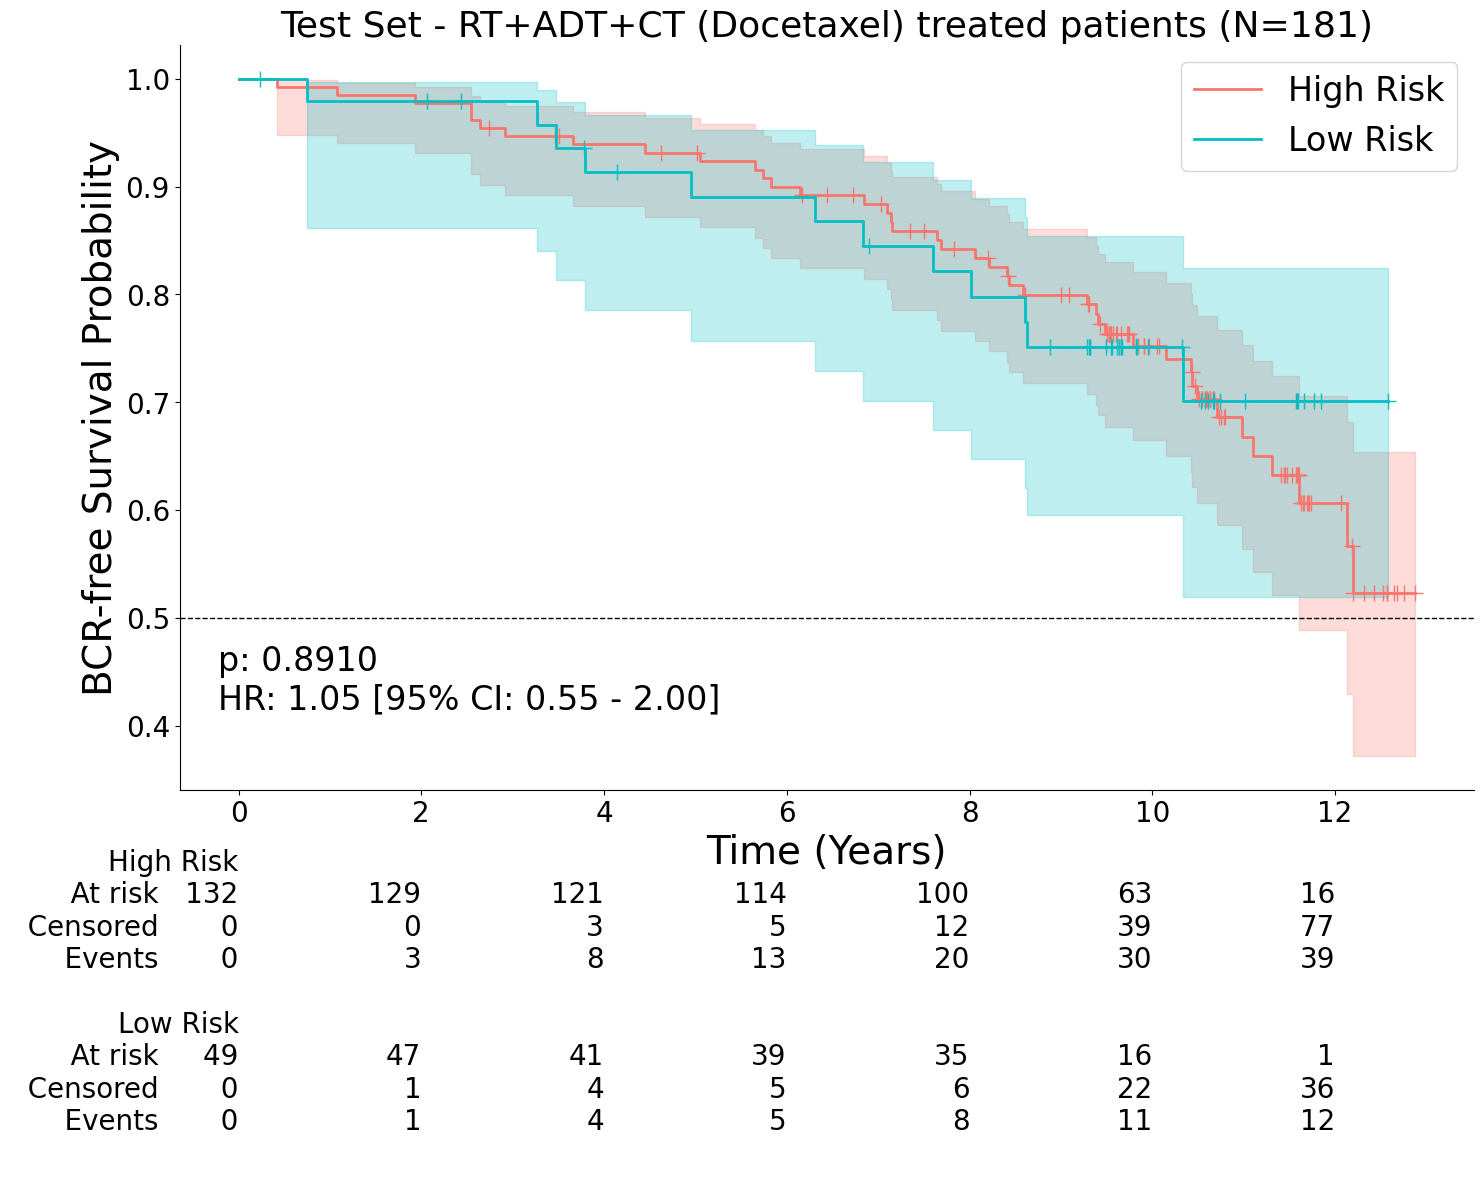

In [72]:
decipher_holdout_title_str = 'Test Set - RT+ADT+CT (Docetaxel) treated patients (N={:d})'.format(len(y_holdout_decipher))
decipher_holdout_figure_save_path = f'/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/KM_curve_holdout_Decipher_{split_percentage}_{scaler_type}_split_{feature_Sel_type}_l1ratio{l1_ratio}.png'
plot_km_curve_lifelines(y_holdout_decipher, decipher_holdout_data_stats, decipher_holdout_figure_save_path, decipher_holdout_title_str)

341


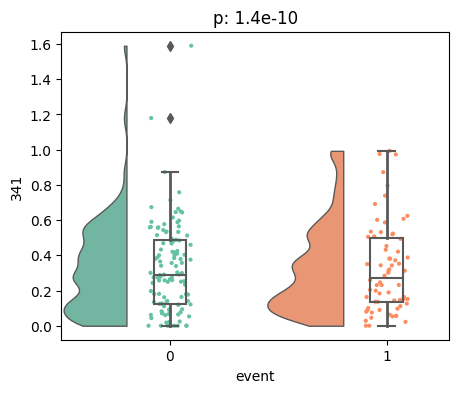

0


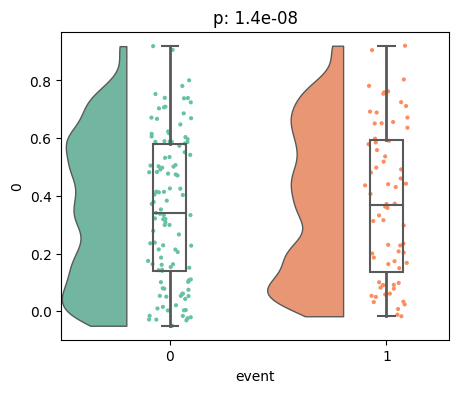

198


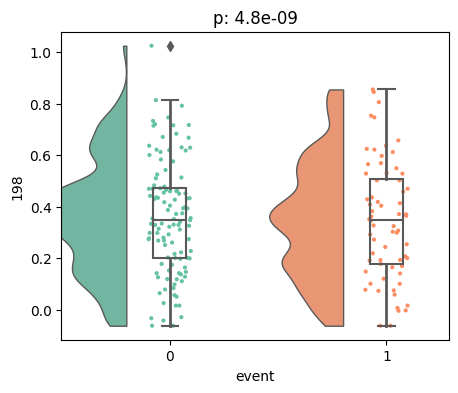

115


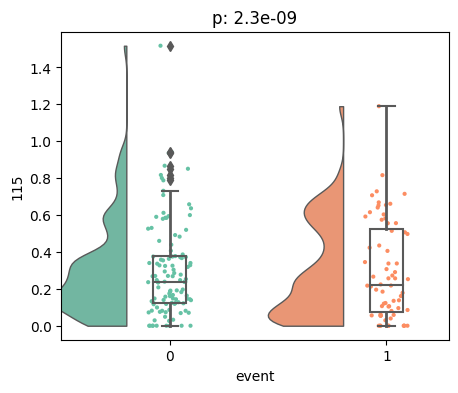

117


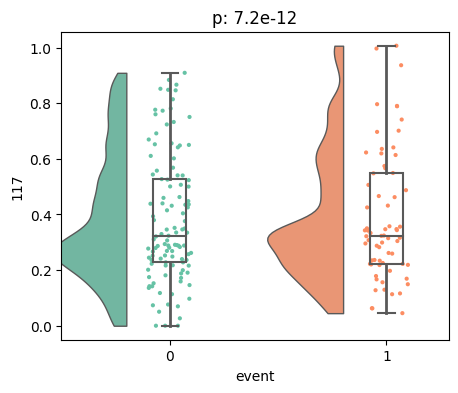

1


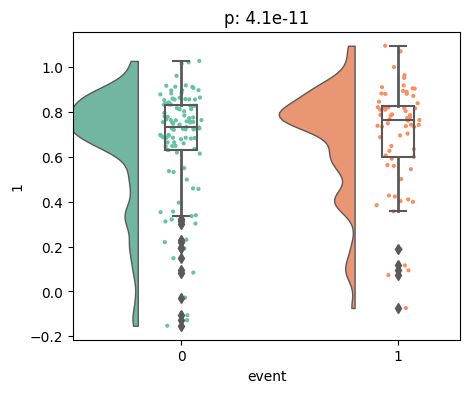

196


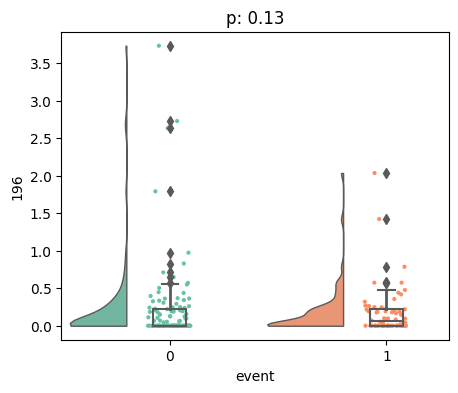

137


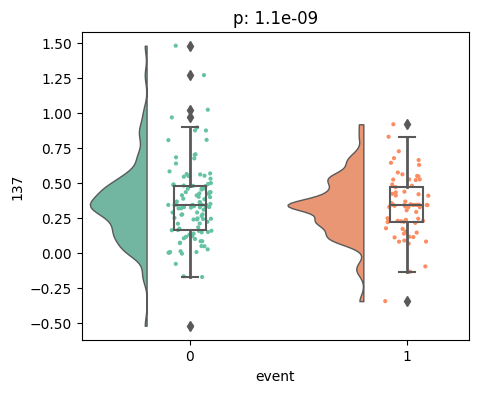

86


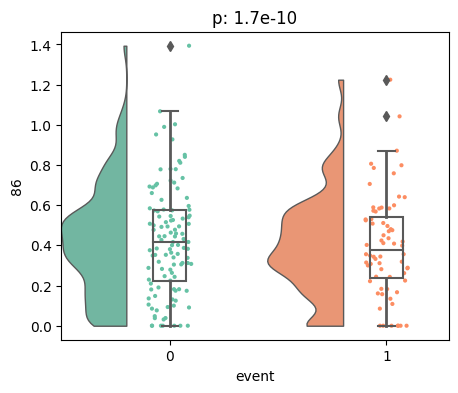

344


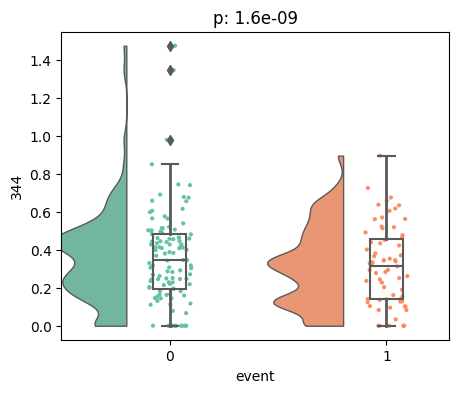

131


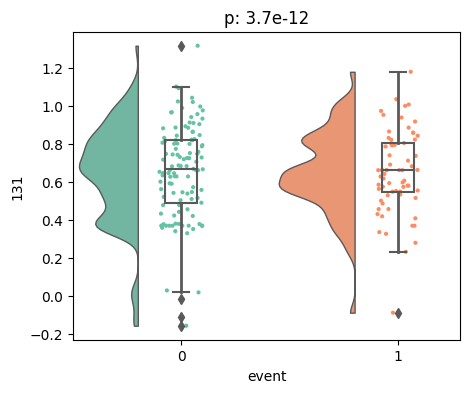

327


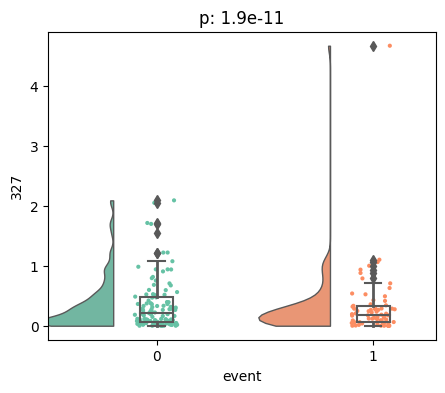

51


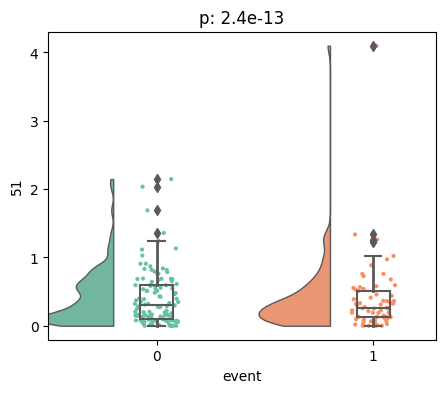

338


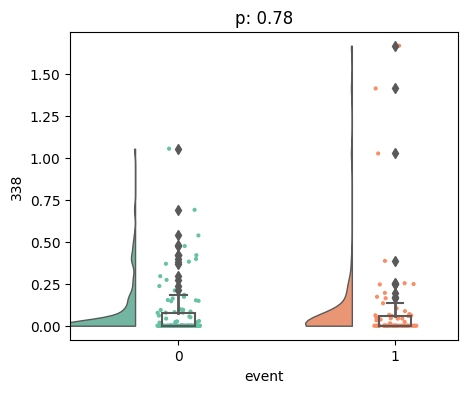

336


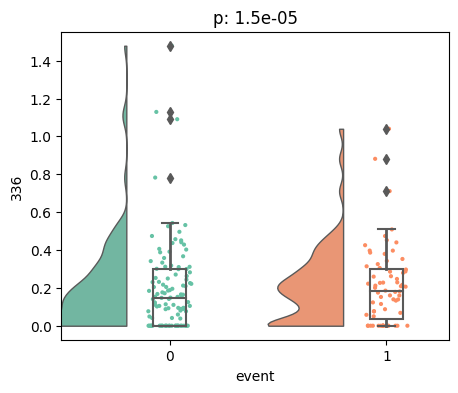

In [73]:
# decipher_features = decipher_features_df.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
# decipher_features = pd.DataFrame(scaler.transform(decipher_features), columns=decipher_features.columns)
# decipher_features = pd.concat([decipher_features_df[['patient_id','event', 'time']], decipher_features], axis=1)

for i, feature in enumerate(X_holdout_decipher_trimmed):
    pvalue = mannwhitneyu(X_holdout_decipher_trimmed[feature], y_holdout_decipher['event']).pvalue
    print(feature)
    plt.figure(figsize=(5,4))
    pt.RainCloud(x=rtog_features['event'], y=X_holdout_decipher_trimmed[feature])
    plt.title(f'p: {pvalue:.2}')
    plt.show()

## UMAP visualization of features

In [74]:
disparity_features = rtog_leg_1.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)
decipher_features = rtog_leg_2.drop(['patient_id','event', 'time'], axis=1).reset_index(drop=True)

In [75]:
disparity_events = rtog_leg_1['event'].values
decipher_events = rtog_leg_2['event'].values

In [76]:
import umap

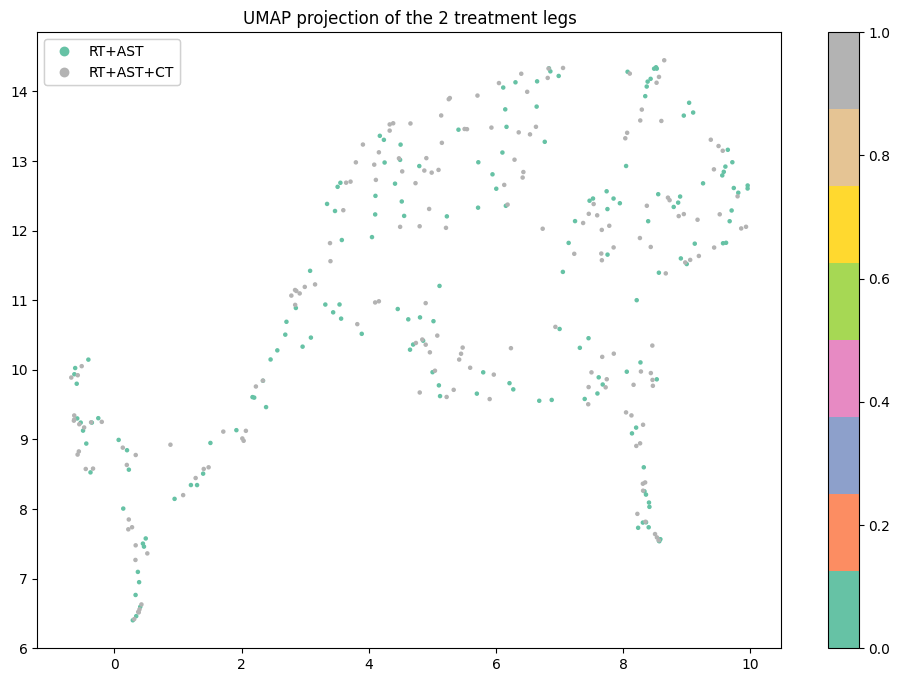

In [77]:
dataset1 = disparity_features.to_numpy()
dataset2 = decipher_features.to_numpy()

# Combine the datasets into a single dataset
combined_data = np.vstack([dataset1, dataset2])

# Create labels for each cohort to color them differently
labels = np.array([0]*len(dataset1) + [1]*len(dataset2))

# Initialize UMAP
reducer = umap.UMAP()

# Fit the model to the combined dataset and transform it
embedding = reducer.fit_transform(combined_data)

# Plotting
combined_labels = np.concatenate([disparity_events, decipher_events])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Set2', s=5)
plt.colorbar()
plt.title('UMAP projection of the 2 treatment legs')
cohorts = ['RT+AST', 'RT+AST+CT']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=cohorts)
plt.gca().add_artist(legend1)

plt.show()

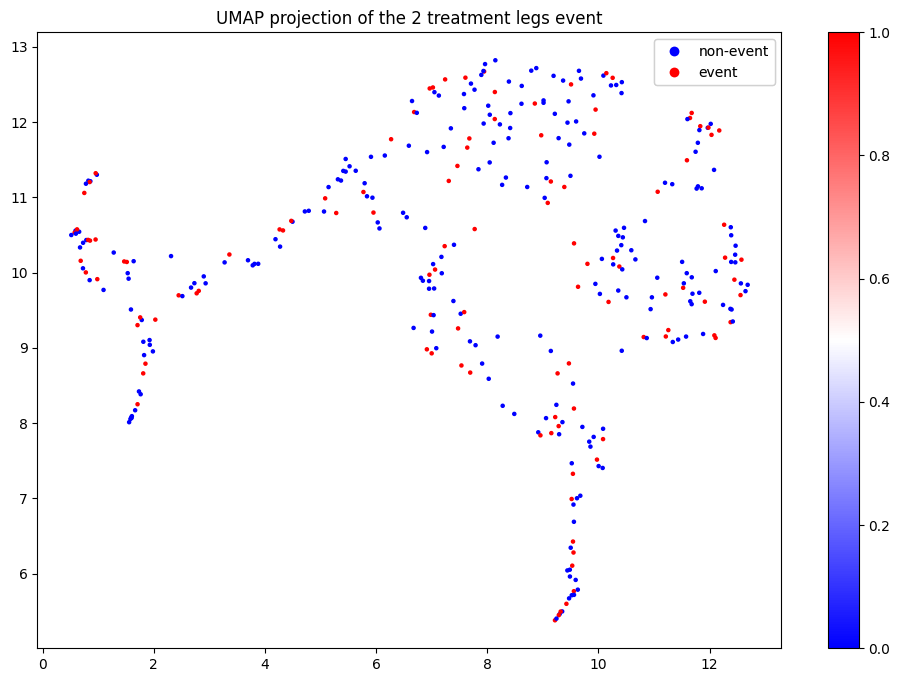

In [78]:
# Combine the datasets into a single dataset
combined_data = np.vstack([dataset1, dataset2])

# Create labels for each cohort to color them differently
labels = np.array([0]*len(dataset1) + [1]*len(dataset2))

# Initialize UMAP
reducer = umap.UMAP()

# Fit the model to the combined dataset and transform it
embedding = reducer.fit_transform(combined_data)

# Plotting
combined_labels = np.concatenate([disparity_events, decipher_events])
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=combined_labels, cmap='bwr', s=5)
plt.colorbar()
plt.title('UMAP projection of the 2 treatment legs event')
cohorts = ['UPenn Disparity', 'Upenn Decipher']
legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=['non-event', 'event'])
plt.gca().add_artist(legend1)

plt.show()

### Favorable outcome patients from both arms

In [79]:
chemo_favorable_risk = y_holdout_decipher[y_holdout_decipher['risk_group'] == 0]

In [80]:
chemo_favorable_risk

,patient_id,event,time,risk_score,risk_group
2,0521-034934,0,9.490411,-0.567792,0
9,0521-056372,1,8.605225,-1.297846,0
11,0521-058489,1,6.310809,-1.244373,0
12,0521-062656,0,0.238356,0.032930,0
17,0521-109333,0,9.613699,-0.331231,0
20,0521-131903,0,6.898630,-3.200058,0
23,0521-140425,1,8.019178,-0.156710,0
24,0521-153775,0,10.328453,-3.412564,0
25,0521-156332,1,3.471233,0.267678,0
30,0521-194808,0,10.536567,0.261100,0


In [81]:
chemo_favorable_risk['chemo'] = 1

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/1183860258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_favorable_risk['chemo'] = 1


In [82]:
no_chemo_favorable_risk = y_holdout[y_holdout['risk_group'] == 0]

In [83]:
no_chemo_favorable_risk['chemo'] = 0

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/765330259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_favorable_risk['chemo'] = 0


In [84]:
no_chemo_favorable_risk

,patient_id,event,time,risk_score,risk_group,chemo
0,0521-011235,0,10.736986,-0.309431,0,0
2,0521-031663,0,9.978082,-1.123451,0,0
3,0521-032790,1,2.810959,-0.000013,0,0
4,0521-042494,0,12.550685,-1.619637,0,0
7,0521-061104,0,11.600000,0.203395,0,0
8,0521-061895,0,4.449315,0.080228,0,0
9,0521-066912,0,8.621918,0.125295,0,0
14,0521-129560,0,10.205756,-1.013853,0,0
15,0521-140656,0,9.487671,0.197849,0,0
16,0521-148325,0,9.928767,0.040051,0,0


In [85]:
# join dfs
favorable_risk = pd.concat([chemo_favorable_risk, no_chemo_favorable_risk])

In [86]:
favorable_risk

,patient_id,event,time,risk_score,risk_group,chemo
2,0521-034934,0,9.490411,-0.567792,0,1
9,0521-056372,1,8.605225,-1.297846,0,1
11,0521-058489,1,6.310809,-1.244373,0,1
12,0521-062656,0,0.238356,0.032930,0,1
17,0521-109333,0,9.613699,-0.331231,0,1
...,...,...,...,...,...,...
76,0521-901993,0,9.904274,-0.558163,0,0
77,0521-907614,1,0.637615,0.146033,0,0
81,0521-931689,0,12.468493,-0.405241,0,0
82,0521-948904,0,4.200000,0.280972,0,0


In [87]:
LL_holdout_decipher

,event,time,risk_group
0,0,9.430781,1
1,0,10.636477,1
2,0,9.490411,0
3,0,5.018340,1
4,0,9.536986,1
...,...,...,...
176,0,12.673973,1
177,0,4.619178,1
178,0,12.649315,1
179,0,10.612606,0


In [88]:
LL_holdout_decipher = favorable_risk.drop(['patient_id', 'risk_group', 'risk_score'], axis=1)
cph_holdout_decipher = CoxPHFitter()
cph_holdout_decipher.fit(LL_holdout_decipher, duration_col='time', event_col='event', show_progress=False)

decipher_holdout_results = cph_holdout_decipher.summary
decipher_holdout_p = multivariate_logrank_test(favorable_risk['time'], favorable_risk['chemo'], favorable_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
decipher_holdout_hr = decipher_holdout_results['exp(coef)'].values[0]
decipher_holdout_ci_lower = decipher_holdout_results['exp(coef) lower 95%'].values[0]
decipher_holdout_ci_upper = decipher_holdout_results['exp(coef) upper 95%'].values[0]
decipher_holdout_log_likelihood = cph_holdout_decipher.log_likelihood_
model_metrics_decipher['holdout_p_value'] = [decipher_holdout_p]
model_metrics_decipher['holdout_hazard_ratio'] = [decipher_holdout_hr]
model_metrics_decipher['holdout_hr_ci_lower'] = [decipher_holdout_ci_lower]
model_metrics_decipher['holdout_hr_ci_upper'] = [decipher_holdout_ci_upper]
model_metrics_decipher['holdout_log_likelihood'] = [decipher_holdout_log_likelihood]
model_metrics_decipher['holdout_parameters'] = [cph_holdout_decipher.params_.shape[0]]

decipher_holdout_data_stats = (decipher_holdout_p, decipher_holdout_hr, decipher_holdout_ci_lower, decipher_holdout_ci_upper)

In [89]:
decipher_holdout_data_stats

(0.7125144938255117, 1.1707705950805114, 0.5056980598919544, 2.710518182723569)

In [90]:
cph_holdout_decipher.print_summary()

<lifelines.CoxPHFitter: fitted with 96 total observations, 74 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 96
number of events observed = 22
   partial log-likelihood = -93.49
         time fit was run = 2024-04-24 15:32:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
chemo       0.16       1.17       0.43            -0.68             1.00                 0.51                 2.71

            cmp to    z    p   -log2(p)
covariate                              
chemo         0.00 0.37 0.71       0.49
---
Concordance = 0.54
Partial AIC = 188.98
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.49

In [91]:
def plot_km_same_risk_group(data_df1, data_df2, data_stats, figure_save_path, title_str):
    
    # Create a colormap
    cmap = plt.cm.get_cmap('Reds')
    # Choose a shade of red
    hr_shade = cmap(0.75)

    cmap = plt.cm.get_cmap('Blues')
    # Choose a shade of red
    lr_shade = cmap(0.75)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    data_high_risk = data_df1
    data_low_risk = data_df2

    kmf_hr = KaplanMeierFitter()
    kmf_hr.fit(data_high_risk['time'], event_observed=data_high_risk['event'], label='RT+ADT')
    kmf_hr.plot_survival_function(ax=ax, color='#f8766d', lw=2, show_censors=True)

    kmf_lr = KaplanMeierFitter()
    kmf_lr.fit(data_low_risk['time'], event_observed=data_low_risk['event'], label='RT+ADT+CT')
    kmf_lr.plot_survival_function(ax=ax, color='#03bfc4', lw=2, show_censors=True, )
    
    
    print("Low risk median survival time: ",kmf_lr.median_survival_time_)
    print("High risk median survival time: ",kmf_hr.median_survival_time_)
    max_median_survival_time = max(kmf_hr.median_survival_time_ , kmf_lr.median_survival_time_)
    if max_median_survival_time == np.inf:
        plt.axhline(y=0.5, color='black', linestyle='--', lw=1)
    else:
        plt.plot([0, max_median_survival_time], [0.5, 0.5], color='black', linestyle='--', lw=1)
    # Vertical lines up to y=0.5, using plot for precise control
    plt.plot([kmf_hr.median_survival_time_, kmf_hr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    plt.plot([kmf_lr.median_survival_time_, kmf_lr.median_survival_time_], [0, 0.5], color='black', linestyle='--', lw=1)
    ax.set_title(title_str, fontsize=26)

    yticks = [np.round(x,1) for x in ax.get_yticks()]
    ax.set_yticklabels(yticks, fontsize=20)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)


    ax.set_xlabel('Time (Years)', fontsize=28)
    ax.set_ylabel('BCR-free Survival Probability', fontsize=28)
    data_p, data_hr, data_ci_lower, data_ci_upper = data_stats
    format_p = lambda p: f"{p:.1e}" if p < 0.001 else f"{p:.4f}"

# Updated string formatting
    data_stats_text = f'p: {format_p(data_p)}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    #data_stats_text = f'p: {data_p:.1e if data_p < 0.001 else data_p:.4f}\nHR: {data_hr:.2f} [95% CI: {data_ci_lower:.2f} - {data_ci_upper:.2f}]'
    ax.text(0.03, 0.1, data_stats_text, transform=ax.transAxes, fontsize=24, verticalalignment='bottom')

    # Add the risk table at the bottom of the KM plot on ax[1] (the bottom subplot)
    sns.despine()
    add_at_risk_counts(kmf_hr, kmf_lr, ax=ax, fontsize=20)
    ax.legend(fontsize=24)
    plt.tight_layout()
    
    fig.savefig(figure_save_path, bbox_inches='tight')
    plt.show()

In [103]:
risk_threshold

0.311966882649811

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/3800088015.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/3800088015.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  inf


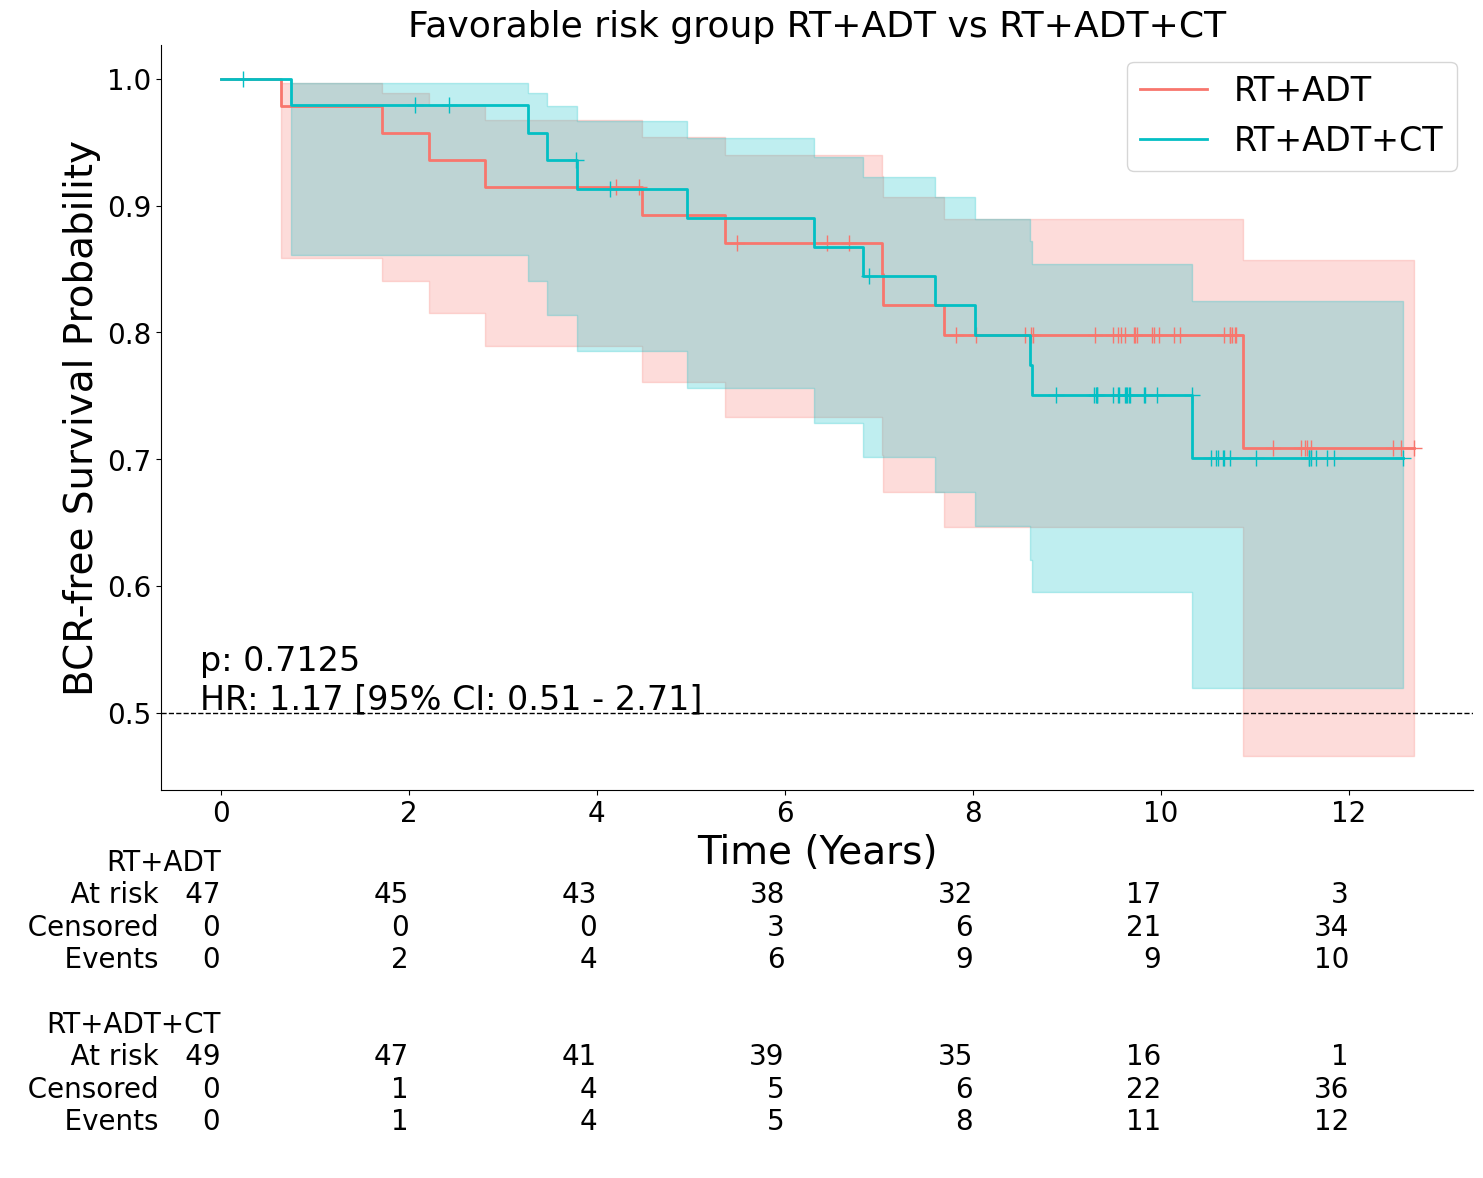

In [92]:
plot_km_same_risk_group(no_chemo_favorable_risk, chemo_favorable_risk, decipher_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/favorable_risk_both_legs_km.png', "Favorable risk group RT+ADT vs RT+ADT+CT")

In [93]:
chemo_bad_risk = y_holdout_decipher[y_holdout_decipher['risk_group'] == 1]
no_chemo_bad_risk = y_holdout[y_holdout['risk_group'] == 1]

In [94]:
chemo_bad_risk['chemo'] = 1

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/2649170415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_bad_risk['chemo'] = 1


In [95]:
no_chemo_bad_risk['chemo'] = 0

/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/910245029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_chemo_bad_risk['chemo'] = 0


In [96]:
bad_risk = pd.concat([chemo_bad_risk, no_chemo_bad_risk])

In [97]:
LL_holdout_decipher = bad_risk.drop(['patient_id', 'risk_group', 'risk_score'], axis=1)
cph_holdout_decipher = CoxPHFitter()
cph_holdout_decipher.fit(LL_holdout_decipher, duration_col='time', event_col='event', show_progress=False)

decipher_holdout_results = cph_holdout_decipher.summary
decipher_holdout_p = multivariate_logrank_test(bad_risk['time'], bad_risk['chemo'], bad_risk['event']).p_value # holdout_results['p'].values[0] # change group to chemo/nochemo
decipher_holdout_hr = decipher_holdout_results['exp(coef)'].values[0]
decipher_holdout_ci_lower = decipher_holdout_results['exp(coef) lower 95%'].values[0]
decipher_holdout_ci_upper = decipher_holdout_results['exp(coef) upper 95%'].values[0]
decipher_holdout_log_likelihood = cph_holdout_decipher.log_likelihood_
model_metrics_decipher['holdout_p_value'] = [decipher_holdout_p]
model_metrics_decipher['holdout_hazard_ratio'] = [decipher_holdout_hr]
model_metrics_decipher['holdout_hr_ci_lower'] = [decipher_holdout_ci_lower]
model_metrics_decipher['holdout_hr_ci_upper'] = [decipher_holdout_ci_upper]
model_metrics_decipher['holdout_log_likelihood'] = [decipher_holdout_log_likelihood]
model_metrics_decipher['holdout_parameters'] = [cph_holdout_decipher.params_.shape[0]]

decipher_holdout_data_stats = (decipher_holdout_p, decipher_holdout_hr, decipher_holdout_ci_lower, decipher_holdout_ci_upper)

In [101]:
decipher_holdout_results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
chemo,-0.582971,0.558237,0.277856,-1.127558,-0.038384,0.323823,0.962343,0.0,-2.098109,0.035896,4.800052


/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/3800088015.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_20193/3800088015.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


Low risk median survival time:  inf
High risk median survival time:  10.83835616


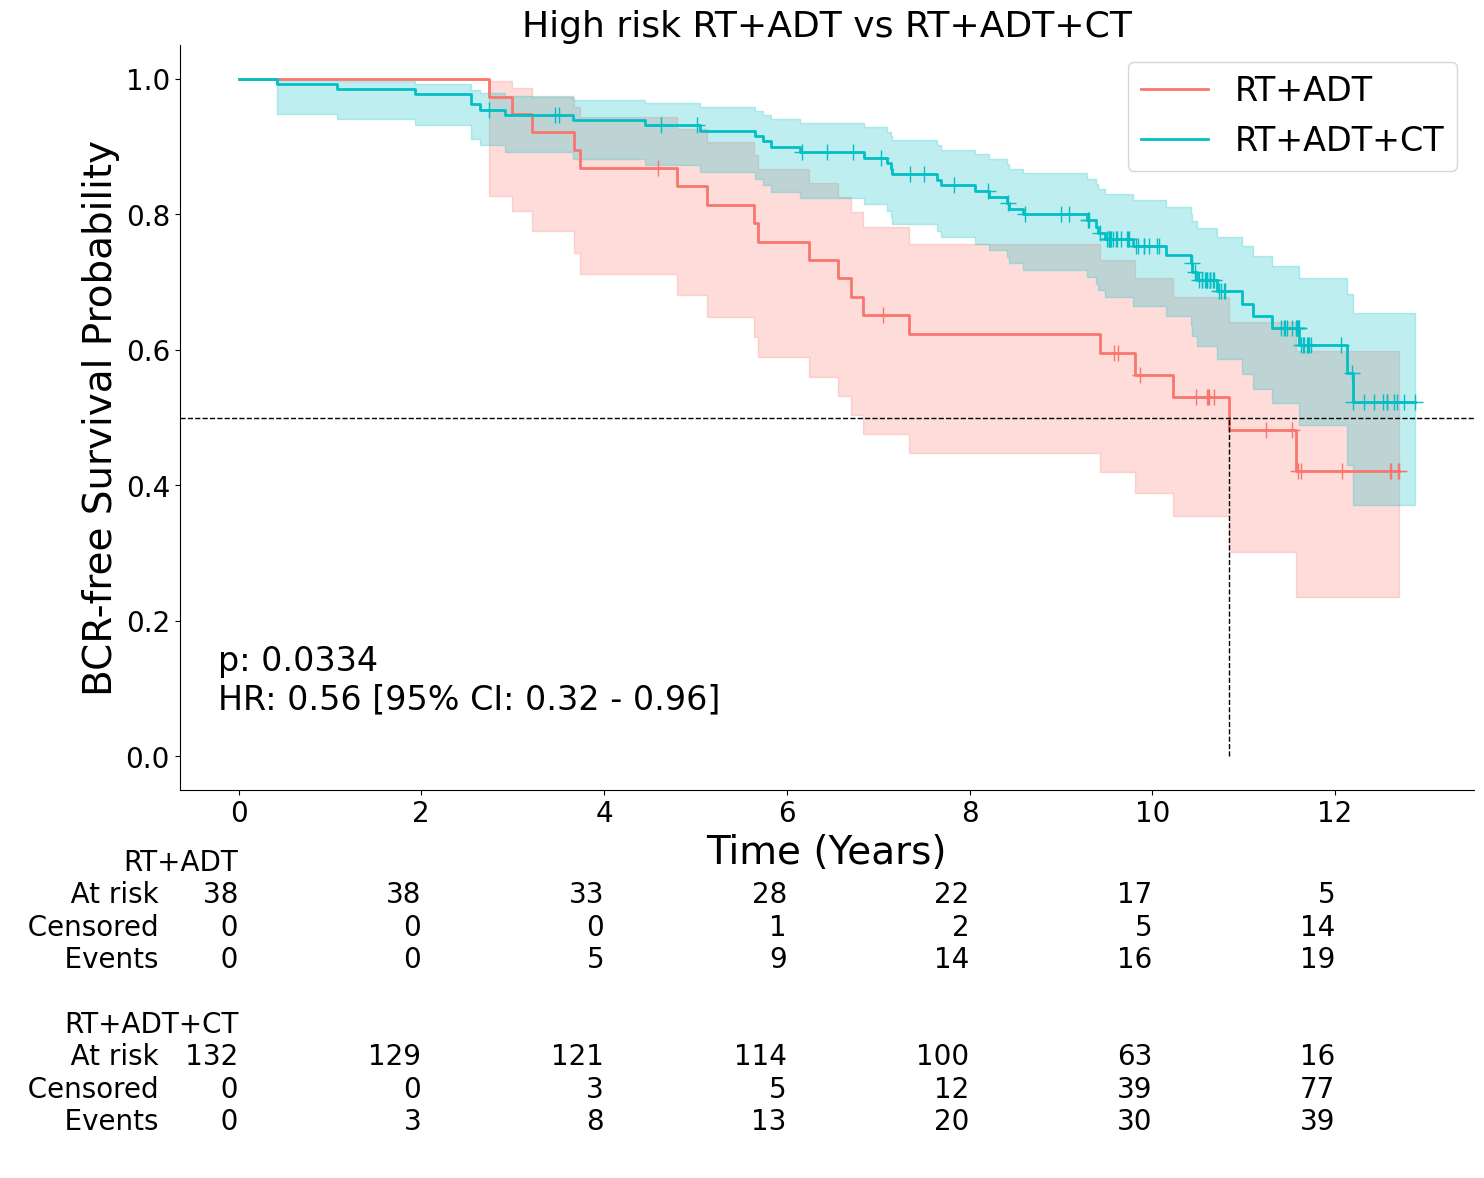

In [98]:
plot_km_same_risk_group(no_chemo_bad_risk, chemo_bad_risk, decipher_holdout_data_stats, '/Users/srmedinac/Documents/BMEPhD/PCa/phenotyping/Bx/RTOG 0521/SpaTIL Features/bad_risk_both_legs_km.png', "High risk RT+ADT vs RT+ADT+CT")

In [99]:
cph_holdout_decipher.print_summary()

<lifelines.CoxPHFitter: fitted with 170 total observations, 110 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 170
number of events observed = 60
   partial log-likelihood = -277.84
         time fit was run = 2024-04-24 15:32:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
chemo      -0.58       0.56       0.28            -1.13            -0.04                 0.32                 0.96

            cmp to     z    p   -log2(p)
covariate                               
chemo         0.00 -2.10 0.04       4.80
---
Concordance = 0.47
Partial AIC = 557.68
log-likelihood ratio test = 4.06 on 1 df
-log2(p) of ll-ratio test = 4.51

In [ ]:
# calculate OS rates for the holdout set

